# Project description



Watching movies in the original language is a popular and effective method to get pumped when learning foreign languages. It is important to choose a film that suits the student's level of difficulty, so that the student understands 50-70% of the dialogues. To meet this condition, the instructor must watch the film and decide what level it corresponds to. This requires a time commitment from the instructor; student and instructor tastes are not always the same.

**project goal**: develop an ML solution to automatically determine the difficulty level of English-language movies based on their subtitles. We will develop a classification for these films based on their difficulty level.

# Project Initialization

load modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# !pip install pysrt
# !pip install wordcloud

import pysrt
import re
import pandas as pd
import glob
import glob
from bs4 import BeautifulSoup

# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !pip install spacy-transformers
# !python -m spacy download en_core_web_sm

import spacy
import requests
from wordcloud import WordCloud
from collections import OrderedDict


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

## Text Normalization

In [4]:
def normalize_srt(subs):
    """ 
  normalize the srt files into one big string 
  excluding all contents within brackets, only get aharacters, digits and punctuations
    """
    pattern_1 = r'[<\(\[{][^>\)\]}]*[>\)\]}]' # all content within <>, (), [], {} (including the brackets)
    pattern_2 = r'[^A-Za-z\',\.?!0-9]' # exclude all characters except for alphabetic letters and punctuation and numbers
    whole_text = ''
    for sub in subs:
        text = re.sub(pattern_1, ' ', sub.text)
        text = re.sub(pattern_2, ' ', text)
        text = ' '.join(text.split())
        whole_text = whole_text + ' ' + text
    return (' '.join(whole_text.split()))

In [5]:
# create film dictionary 
# film_title as key, film_subs as value
film_dict = {}
for file_path in glob.glob('./data/*.srt'):

  # normalize the file path to retrieve film title
    film_title = re.sub(r'.\/data\\', '', file_path)
    film_title = re.sub(r'.srt', '', film_title)
    film_title = re.sub(r'\([^\)]*\)', '', film_title)
    film_title = re.sub(r'_', ' ', film_title)
    film_subs = pysrt.open(file_path)
    film_subs = normalize_srt(film_subs)
    film_dict[film_title] = film_subs

- First import the srt files into one big string
    - exclude all contents within brackets, which are (), [], {}
    - only get characters, digits and punctuations  
- then create a dictionary of key as film title and value as film subtitles.

In [6]:
film_dict.keys()

dict_keys(['10 Cloverfield lane', '10 things I hate about you', 'Aladdin', 'All dogs go to heaven', 'An American tail', 'A knights tale', 'A star is born', 'Babe', 'Back to the future', 'Batman begins', 'Beauty and the beast', 'Before I go to sleep', 'Before sunrise', 'Before sunset', 'Braveheart', 'Bridget Jones diary', 'Cast away', 'Catch me if you can', 'Clueless', 'Deadpool', 'Die hard', 'Dredd', 'Dune', 'Eurovision song contest ', 'Fight club', 'Finding Nemo', 'Forrest Gump', 'Good Will Hunting', 'Groundhog day', 'Harry Potter and the philosophers stone', 'Her', 'Home alone', 'Hook', 'House of Gucci', 'Inside out', 'It s a wonderful life', 'Knives out', 'Kubo and the two strings', 'Liar liar', 'Lion', 'Logan', 'Love actually', 'Mamma Mia', 'Mary Poppins returns', 'Matilda', 'Meet the parents', 'Moulin Rouge', 'Mrs Doubtfire', 'My big fat Greek wedding', 'Notting Hill', 'Pirates of the Caribbean', 'Pleasantville', 'Powder', 'Pulp fiction', 'Ready or not', 'Shrek', 'Sleepless in Sea

From the dictionary we then create a dataframe with each row represents one movie

In [7]:
df = pd.DataFrame.from_dict(film_dict, orient='index')
df.columns = ['subs']

In [8]:
df

subs
10 Cloverfield lane         Fixed Synced by bozxphd. Enjoy The Flick BEN O...
10 things I hate about you  Hey! I'll be right with you. So, Cameron. Here...
Aladdin                     Oh, I come from a land From a faraway place Wh...
All dogs go to heaven       CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...
An American tail            MAMA Tanya, Fievel? Will you stop that twirlin...
...                                                                       ...
Twilight                    I'd never given much thought to how I would di...
Up                          Movietown News presents Spotlight on Adventure...
Venom                       Life Foundation Control, this is LF1. The spec...
Warm bodies                 What am I doing with my life? I'm so pale. I s...
We are the Millers          Oh, my God... ...it's full on double rainbow a...

[86 rows x 1 columns]

## Text Lemmatization

- lemmatize the word in subtitles to root form ==> to calculate the vocabulary coverage 
- To note:  
    - will exclude interjection tokens (e.g. 'ah, haha, ahh'), white space tokens, tokens belong to the stop words  
    - will also try to exclude tokens which are NAMES!  

In [9]:
nlp = spacy.load('en_core_web_sm')
def lemmatize_text(text):
    """
    lemmatize the word in subtitles to root form
    To note:
    will exclude interjection tokens, white space tokens, tokens belong to the stop words,
    will also try to exclude tokens which are NAMES!
    """

    # exclude the punctuations from text
    text = re.sub(r'[^A-Za-z\']', ' ', text)

    # list of top 10 frequent appearing proper noun: they are highly likely to be names
    doc = nlp(text)
    propn = {}
    for token in doc:
        if token.pos_ == 'PROPN':
            if token.text.lower() in propn:
                propn[token.text.lower()] += 1
        else:
            propn[token.text.lower()] = 1
    # sort the propn dic from the highest counts
    sorted_dic = OrderedDict()
    sorted_key = sorted(propn, reverse=True, key=propn.get)
    for key in sorted_key:
        sorted_dic[key] = propn[key]
        names = list(sorted_dic.keys())[:9]

    # exclude all interjection tokens, white space tokens and tokens belong to the stop words
    # exclude names tokens, tokens with single character
    # then perform the lemmatization)
    lemmas = []
    stopwords.update(["'s", "'ve", "'", "'m", "' m", 'I', 'would'])
    doc = nlp(text.lower())
    for token in doc:
        if token.pos_ != 'INTJ' and token.lemma_ not in stopwords and not token.is_space and token.text not in names and len(token) > 1:
            lemmas.append(token.lemma_)
    return ' '.join(lemmas)


In [10]:
df['subs_lemma'] = df['subs'].apply(lambda x: lemmatize_text(x))

In [11]:
df

subs  \
10 Cloverfield lane         Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
10 things I hate about you  Hey! I'll be right with you. So, Cameron. Here...   
Aladdin                     Oh, I come from a land From a faraway place Wh...   
All dogs go to heaven       CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
An American tail            MAMA Tanya, Fievel? Will you stop that twirlin...   
...                                                                       ...   
Twilight                    I'd never given much thought to how I would di...   
Up                          Movietown News presents Spotlight on Adventure...   
Venom                       Life Foundation Control, this is LF1. The spec...   
Warm bodies                 What am I doing with my life? I'm so pale. I s...   
We are the Millers          Oh, my God... ...it's full on double rainbow a...   

                                                                   subs_lemma  
10 Cloverfield lane         fix sync bozxphd enjoy flick ben phone michell...  
10 things I hate about you  right cameron go nine school year army brat en...  
Aladdin                     come land faraway place caravan camel roam fla...  
All dogs go to heaven       captioning make possible mgm home entertainmen...  
An American tail            tanya fievel stop twirl twirl time bed come ha...  
...                                                                       ...  
Twilight                    never give much thought die die place someone ...  
Up                          movietown news present spotlight adventure wit...  
Venom                       life foundation control lf specimen secure hea...  
Warm bodies                 life pale get eat well posture terrible stand ...  
We are the Millers          full double rainbow across sky whoa god whoo m...  

[86 rows x 2 columns]

one example of the subtitles of 10 things i hate about you after the abovie mentioned lemmatization.  

In [12]:
df.iloc[1, 1]

"right cameron go nine school year army brat enough sure find padua different old school little ass wipe brain everywhere excuse say right office anymore get deviant see novel finish thank thank lot patrick verona see make visit weekly ritual moment together hit light clever kangaroo boy say expose cafeteria joke lunch lady optimist next time keep pouch michael eckman suppose show around thank god know normally send one audio visual geek know mean michael put slide michael cameron breakdown get basic beautiful people listen unless talk first bother wait rule watch eat see left coffee kid costa rican butthead edgy make sudden movement around delusional white rasta big marley fan think black semi political mostly smoke lot weed guy wait wait let guess cowboy close come cow mcdonald mcdonald future mvys ivy league accept yuppie greed back friend guy close bogey yesterday god happen bogey lozenstein start buy izod outlet mall kick hostile takeover worry pay group even think group bianca st

## Create features

create features (numbers) from texts, so we can build our machine learning model

### raw text features

- mean and std value of sentence length (number of non punctuation tokens in one sentence)  
- number of sentences  
-  mean and std values of token length (number of characters in a token)    
- the number of lemmas and the number of unique lemmas

In [13]:
def text_features(subs):
    """
      get the mean and std value of sentence length (number of non punctuation tokens in one sentence)
      get the number of sentences
      get the mean and std values of token length (number of characters in a token)
    """
    doc = nlp(subs)
    sent_length = []
    token_length = []
    for sent in doc.sents:
        sent_length.append(len([token for token in sent if not token.is_punct]))
        token_length.append([len(token) for token in sent if not token.is_punct])

    sent_len = round(np.mean(sent_length), 2)
    sent_len_std = round(np.std(sent_length), 2)
    sent_cnt = len(list(doc.sents))

    token_length = [num for lists in token_length for num in lists]
    tok_len = np.mean(token_length).round(2)
    tok_len_std = np.std(token_length).round(2)

    return sent_len, sent_len_std, sent_cnt, tok_len, tok_len_std

def tok_cnt(subs_lemma):
    """
    get the number of lemmas and the number of unique lemmas
    """
    tok_cnt = len(subs_lemma.split())
    unique_tok_cnt = len(set(subs_lemma.split()))
    return tok_cnt, unique_tok_cnt


In [14]:
df['tok_cnt'], df['uniq_tok_cnt'] = zip(*df['subs_lemma'].apply(tok_cnt))
df['sent_len'], df['sent_len_std'], df['sent_cnt'], df['tok_len'], df['tok_len_std'] = zip(*df['subs'].apply(text_features))

In [15]:
df.head()

subs  \
10 Cloverfield lane         Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
10 things I hate about you  Hey! I'll be right with you. So, Cameron. Here...   
Aladdin                     Oh, I come from a land From a faraway place Wh...   
All dogs go to heaven       CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
An American tail            MAMA Tanya, Fievel? Will you stop that twirlin...   

                                                                   subs_lemma  \
10 Cloverfield lane         fix sync bozxphd enjoy flick ben phone michell...   
10 things I hate about you  right cameron go nine school year army brat en...   
Aladdin                     come land faraway place caravan camel roam fla...   
All dogs go to heaven       captioning make possible mgm home entertainmen...   
An American tail            tanya fievel stop twirl twirl time bed come ha...   

                            tok_cnt  uniq_tok_cnt  sent_len  sent_len_std  \
10 Cloverfield lane            2007           759      5.84          4.93   
10 things I hate about you     3542          1254      5.95          5.41   
Aladdin                        3578          1169      5.54          6.42   
All dogs go to heaven          3460           909      4.54          4.49   
An American tail               2185           678      4.79          5.85   

                            sent_cnt  tok_len  tok_len_std  
10 Cloverfield lane              891     3.78         1.91  
10 things I hate about you      1488     3.75         1.91  
Aladdin                         1533     3.75         1.89  
All dogs go to heaven           1717     3.77         1.81  
An American tail                1100     3.75         1.81

### Lexial features

- vocabulary difficult level    
    - calculate the number of subtitles' words according to the CEFR difficulty level, include the words which do not fit into any category  

In [16]:
# load english vocabularies with difficulty levels according to CEFR
# a1, a2, b1, b2, c1
a1 = pd.read_csv('./vocabulary/The_Oxford_3000_by_CEFR_level_A1.txt', sep='\t')
a2 = pd.read_csv('./vocabulary/The_Oxford_3000_by_CEFR_level_A2.txt', sep='\t')
b1 = pd.read_csv('./vocabulary/The_Oxford_3000_by_CEFR_level_B1.txt', sep='\t')
b2 = pd.read_csv('./vocabulary/The_Oxford_3000_by_CEFR_level_B2.txt', sep='\t')
c1 = pd.read_csv('./vocabulary/The_Oxford_5000_by_CEFR_level_C1.txt', sep='\t')
vocab_list = [a1, a2, b1, b2, c1]

def get_first_word(text):
  first_word = text.split(' ')[0]
  return first_word
  
for vocab in vocab_list:
  vocab['word'] = vocab.iloc[:, 0].apply(lambda x: get_first_word(x))

oxford_words = []
for vocab in vocab_list:
  oxford_words.extend(list(vocab['word']))
print(f'The oxford 3000 dictionary by CEFR levle has {len(oxford_words)} words')

The oxford 3000 dictionary by CEFR levle has 4563 words


In [17]:
def vocab_cefr(subs_lemma):
  """
  calculate the percentages of subtitles' words according to the CEFR difficulty level
  include the words which do not fit into any category
  """
  word_cnt = len(subs_lemma.split())
  a1_cnt, a2_cnt, b1_cnt, b2_cnt, c1_cnt, other_cnt = 0, 0, 0, 0, 0, 0
  others = ''
  for word in subs_lemma.split():
    if word in list(a1['word']):
      a1_cnt += 1
    elif word in list(a2['word']):
      a2_cnt += 1
    elif word in list(b1['word']):
      b1_cnt += 1
    elif word in list(b2['word']):
      b2_cnt += 1
    elif word in list(c1['word']):
      c1_cnt += 1
    else:
      other_cnt += 1
      others = others + ' ' + word
  return a1_cnt, a2_cnt, b1_cnt, b2_cnt, c1_cnt, other_cnt, others
  # return (round(a1_cnt*100/word_cnt, 2),
  #         round(a2_cnt*100/word_cnt, 2),
  #         round(b1_cnt*100/word_cnt, 2),
  #         round(a2_cnt*100/word_cnt, 2), 
  #         round(c1_cnt*100/word_cnt, 2),
  #         round(other_cnt*100/word_cnt, 2),
  #         others)


In [18]:
df['a1_%'], df['a2_%'], df['b1_%'], df['b2_%'], df['c1_%'], df['other_%'], df['other_word'] = zip(*df['subs_lemma'].apply(vocab_cefr))

In [19]:
df

subs  \
10 Cloverfield lane         Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
10 things I hate about you  Hey! I'll be right with you. So, Cameron. Here...   
Aladdin                     Oh, I come from a land From a faraway place Wh...   
All dogs go to heaven       CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
An American tail            MAMA Tanya, Fievel? Will you stop that twirlin...   
...                                                                       ...   
Twilight                    I'd never given much thought to how I would di...   
Up                          Movietown News presents Spotlight on Adventure...   
Venom                       Life Foundation Control, this is LF1. The spec...   
Warm bodies                 What am I doing with my life? I'm so pale. I s...   
We are the Millers          Oh, my God... ...it's full on double rainbow a...   

                                                                   subs_lemma  \
10 Cloverfield lane         fix sync bozxphd enjoy flick ben phone michell...   
10 things I hate about you  right cameron go nine school year army brat en...   
Aladdin                     come land faraway place caravan camel roam fla...   
All dogs go to heaven       captioning make possible mgm home entertainmen...   
An American tail            tanya fievel stop twirl twirl time bed come ha...   
...                                                                       ...   
Twilight                    never give much thought die die place someone ...   
Up                          movietown news present spotlight adventure wit...   
Venom                       life foundation control lf specimen secure hea...   
Warm bodies                 life pale get eat well posture terrible stand ...   
We are the Millers          full double rainbow across sky whoa god whoo m...   

                            tok_cnt  uniq_tok_cnt  sent_len  sent_len_std  \
10 Cloverfield lane            2007           759      5.84          4.93   
10 things I hate about you     3542          1254      5.95          5.41   
Aladdin                        3578          1169      5.54          6.42   
All dogs go to heaven          3460           909      4.54          4.49   
An American tail               2185           678      4.79          5.85   
...                             ...           ...       ...           ...   
Twilight                       3820          1108      5.50          5.93   
Up                             2545           865      4.86          4.59   
Venom                          3390          1047      5.01          4.40   
Warm bodies                    1873           639      4.93          3.99   
We are the Millers             6439          1609      4.88          4.21   

                            sent_cnt  tok_len  tok_len_std  a1_%  a2_%  b1_%  \
10 Cloverfield lane              891     3.78         1.91  1261   242   121   
10 things I hate about you      1488     3.75         1.91  2074   351   165   
Aladdin                         1533     3.75         1.89  1717   442   308   
All dogs go to heaven           1717     3.77         1.81  1831   391   142   
An American tail                1100     3.75         1.81  1314   184   119   
...                              ...      ...          ...   ...   ...   ...   
Twilight                        1775     3.68         1.81  2367   483   171   
Up                              1270     3.78         1.96  1386   281   133   
Venom                           1740     3.72         1.90  1881   400   142   
Warm bodies                     1014     3.63         1.86  1154   261    81   
We are the Millers              3295     3.63         1.80  3607   763   295   

                            b2_%  c1_%  other_%  \
10 Cloverfield lane           48    32      303   
10 things I hate about you    96    75      781   
Aladdin                       96    81      934   
All dogs go to heaven         85    5

- Lexical diversity  
    - Ratio between the total number of words and the total number of unique words  
    - based on either raw text or lemmatized text

In [20]:
def lex_diverse(subs):
    """
  Ratio between the total number of words and the total number of unique words
    """
    word_list = re.findall(r'[\w]+', subs)
    return round(len(set(word_list)) / len(word_list), 3)

In [21]:
df['lex_div'] = df['subs'].apply(lex_diverse)
df['lemma_div'] = (df['uniq_tok_cnt'] / df['tok_cnt']).round(3)

In [22]:
df

subs  \
10 Cloverfield lane         Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
10 things I hate about you  Hey! I'll be right with you. So, Cameron. Here...   
Aladdin                     Oh, I come from a land From a faraway place Wh...   
All dogs go to heaven       CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
An American tail            MAMA Tanya, Fievel? Will you stop that twirlin...   
...                                                                       ...   
Twilight                    I'd never given much thought to how I would di...   
Up                          Movietown News presents Spotlight on Adventure...   
Venom                       Life Foundation Control, this is LF1. The spec...   
Warm bodies                 What am I doing with my life? I'm so pale. I s...   
We are the Millers          Oh, my God... ...it's full on double rainbow a...   

                                                                   subs_lemma  \
10 Cloverfield lane         fix sync bozxphd enjoy flick ben phone michell...   
10 things I hate about you  right cameron go nine school year army brat en...   
Aladdin                     come land faraway place caravan camel roam fla...   
All dogs go to heaven       captioning make possible mgm home entertainmen...   
An American tail            tanya fievel stop twirl twirl time bed come ha...   
...                                                                       ...   
Twilight                    never give much thought die die place someone ...   
Up                          movietown news present spotlight adventure wit...   
Venom                       life foundation control lf specimen secure hea...   
Warm bodies                 life pale get eat well posture terrible stand ...   
We are the Millers          full double rainbow across sky whoa god whoo m...   

                            tok_cnt  uniq_tok_cnt  sent_len  sent_len_std  \
10 Cloverfield lane            2007           759      5.84          4.93   
10 things I hate about you     3542          1254      5.95          5.41   
Aladdin                        3578          1169      5.54          6.42   
All dogs go to heaven          3460           909      4.54          4.49   
An American tail               2185           678      4.79          5.85   
...                             ...           ...       ...           ...   
Twilight                       3820          1108      5.50          5.93   
Up                             2545           865      4.86          4.59   
Venom                          3390          1047      5.01          4.40   
Warm bodies                    1873           639      4.93          3.99   
We are the Millers             6439          1609      4.88          4.21   

                            sent_cnt  tok_len  tok_len_std  a1_%  a2_%  b1_%  \
10 Cloverfield lane              891     3.78         1.91  1261   242   121   
10 things I hate about you      1488     3.75         1.91  2074   351   165   
Aladdin                         1533     3.75         1.89  1717   442   308   
All dogs go to heaven           1717     3.77         1.81  1831   391   142   
An American tail                1100     3.75         1.81  1314   184   119   
...                              ...      ...          ...   ...   ...   ...   
Twilight                        1775     3.68         1.81  2367   483   171   
Up                              1270     3.78         1.96  1386   281   133   
Venom                           1740     3.72         1.90  1881   400   142   
Warm bodies                     1014     3.63         1.86  1154   261    81   
We are the Millers              3295     3.63         1.80  3607   763   295   

                            b2_%  c1_%  other_%  \
10 Cloverfield lane           48    32      303   
10 things I hate about you    96    75      781   
Aladdin                       96    81      934   
All dogs go to heaven         85    5

### Spacy Dependency parsing tree height

- The height of the dependency tree can be an indicator for text complexity.  
- The heigher the tree grows, the more complex the gramatic structure become.    



In [23]:
def tree_height(root):
    """
  function to get the max depth of a dependency parsing tree
  if the root.children list not empty
  go deeper to the child, then try to find if the child token has its own child
  recursion process
    """
  # exclude the punctuation token
    if not [child for child in root.children if child.pos_ != 'PUNCT']:
        return 1
    else:
        return 1 + max(tree_height(child) for child in root.children if child.pos_ != 'PUNCT')


def tree_height_stats(subs):
    """
  function to get the tree height stats of the subtitles
  calculate the tree height for each sentence
  return the mean value and std
    """
    doc = nlp(subs)
    heights = []
    for sent in doc.sents:
        root = sent.root 
        heights.append(tree_height(root))
    return round(np.mean(heights), 2), round(np.std(heights), 2), np.max(heights)


In [24]:
df['tree_height'], df['tree_height_std'], df['max_tree_height'] = zip(*df['subs'].apply(tree_height_stats))


In [25]:
df = df.reset_index()

In [26]:
df = df.rename(columns={'index': 'title'})

In [27]:
df

title  \
0          10 Cloverfield lane   
1   10 things I hate about you   
2                      Aladdin   
3        All dogs go to heaven   
4             An American tail   
..                         ...   
81                    Twilight   
82                          Up   
83                       Venom   
84                 Warm bodies   
85          We are the Millers   

                                                 subs  \
0   Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
1   Hey! I'll be right with you. So, Cameron. Here...   
2   Oh, I come from a land From a faraway place Wh...   
3   CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
4   MAMA Tanya, Fievel? Will you stop that twirlin...   
..                                                ...   
81  I'd never given much thought to how I would di...   
82  Movietown News presents Spotlight on Adventure...   
83  Life Foundation Control, this is LF1. The spec...   
84  What am I doing with my life? I'm so pale. I s...   
85  Oh, my God... ...it's full on double rainbow a...   

                                           subs_lemma  tok_cnt  uniq_tok_cnt  \
0   fix sync bozxphd enjoy flick ben phone michell...     2007           759   
1   right cameron go nine school year army brat en...     3542          1254   
2   come land faraway place caravan camel roam fla...     3578          1169   
3   captioning make possible mgm home entertainmen...     3460           909   
4   tanya fievel stop twirl twirl time bed come ha...     2185           678   
..                                                ...      ...           ...   
81  never give much thought die die place someone ...     3820          1108   
82  movietown news present spotlight adventure wit...     2545           865   
83  life foundation control lf specimen secure hea...     3390          1047   
84  life pale get eat well posture terrible stand ...     1873           639   
85  full double rainbow across sky whoa god whoo m...     6439          1609   

    sent_len  sent_len_std  sent_cnt  tok_len  tok_len_std  ...  b1_%  b2_%  \
0       5.84          4.93       891     3.78         1.91  ...   121    48   
1       5.95          5.41      1488     3.75         1.91  ...   165    96   
2       5.54          6.42      1533     3.75         1.89  ...   308    96   
3       4.54          4.49      1717     3.77         1.81  ...   142    85   
4       4.79          5.85      1100     3.75         1.81  ...   119    37   
..       ...           ...       ...      ...          ...  ...   ...   ...   
81      5.50          5.93      1775     3.68         1.81  ...   171    79   
82      4.86          4.59      1270     3.78         1.96  ...   133    73   
83      5.01          4.40      1740     3.72         1.90  ...   142   145   
84      4.93          3.99      1014     3.63         1.86  ...    81    46   
85      4.88          4.21      3295     3.63         1.80  ...   295   144   

    c1_%  other_%                                         other_word  lex_div  \
0     32      303   sync bozxphd flick ben michelle michelle mich...    0.231   
1     75      781   cameron year brat padua ass anymore deviant p...    0.204   
2     81      934   faraway caravan camel roam barbaric hop arabi...    0.212   
3     58      953   captioning mgm itchy tap yow itchy idgi idgi ...    0.157   
4     29      502   tanya fievel twirl twirl hanukkah hanukkah fi...    0.214   
..   ...      ...                                                ...      ...   
81    53      667   phoenix erratic harebrained okay renee thorn ...    0.173   
82    33      639   movietown witness civilized world america lur...    0.220   
83    78      744   foundation lf roger lf reentry reentry shit l...    0.184   
84    39      292   posture straighter jesus wish anymore hoodie ...    0.213   
85   116     1514   rainbow whoa whoo vivid triple rainbow streak...    0.151   

   lemma_div  tree_height  tree_height_std  max_

### Spacy Part of speech (POS) count

consider the following univsersal POS tag   
'UH',
 'PRP',
 'VBP',
 'RB',
 'VBG',
 'DT',
 'NNP',
 'NN',
 'CC',
 'WP',
 'JJ',
 'IN',
 'RP',
 'PRP$',
 'NNS',
 'VBZ',
 'JJS',
 'VBN',
 'CD',
 'TO',
 'VB',
 'WRB',
 'VBD',
 'MD',
 'POS',
 'JJR',
 'WDT',
 'NNPS',
 'RBR',
 'FW',
 'EX',
 'PDT',
 'RBS',
 'LS',
 'WP$']

We will count their appearances for each movie

In [28]:
pos_tags = ['UH',
 'PRP',
 'VBP',
 'RB',
 'VBG',
 'DT',
 'NNP',
 'NN',
 'CC',
 'WP',
 'JJ',
 'IN',
 'RP',
 'PRP$',
 'NNS',
 'VBZ',
 'JJS',
 'VBN',
 'CD',
 'TO',
 'VB',
 'WRB',
 'VBD',
 'MD',
 'POS',
 'JJR',
 'WDT',
 'NNPS',
 'RBR',
 'FW',
 'EX',
 'PDT',
 'RBS',
 'LS',
 'WP$']

In [29]:
from scipy.stats import entropy
import math

def pos_tag_pct(subs):
    """
    count each pos tag (except punctuation) in the subtitle sentences then divide with number of sentences
    calculate the entropy of POS tags distributions

    Arg:
    subs ==> movie subtiles text

    return:
    percentages of pos tags, entropy of distribution 
    """
    doc = nlp(subs)
    tags = []
    for token in doc:
        if not token.is_punct:
            tags.append(token.tag_)

    tags_cnt = []
    for tag in pos_tags:
        tag_cnt = tags.count(tag)
        tags_cnt.append(tag_cnt)
    # tags_pct = [num/len(tags) for num in tags_cnt]
    tag_entropy = entropy(tags_cnt, base=2)
    normalized_tag_entropy = tag_entropy / math.log(len(pos_tags), 2)
    return tags_cnt, round(normalized_tag_entropy, 3)
    # return [round(num, 3) for num in tags_pct], round(normalized_tag_entropy, 3)


In [30]:
tags_pct_whole = []
tags_entropy_list = []
for i in range(df.shape[0]):
    tags_pct, tags_entropy = pos_tag_pct(df.loc[i, 'subs'])
    tags_pct_whole.append(tags_pct)
    tags_entropy_list.append(tags_entropy)

In [31]:
tags_pct_df = pd.DataFrame(tags_pct_whole, columns = pos_tags)
tags_pct_df['pos_tag_entrophy'] = tags_entropy_list 

In [32]:
tags_pct_df

UH   PRP   VBP    RB  VBG    DT   NNP    NN   CC   WP  ...  WDT  NNPS  \
0    156   797   291   462  127   405   180   515  136   85  ...   17     6   
1    322  1386   624   759  175   638   384   909  172  125  ...   23     2   
2    350  1138   449   662  108   693   577   913  144  101  ...    6     1   
3    180   783   349   350   93   552  2226   718  159  106  ...    6     7   
4    278   636   286   456   87   397   459   568  126   61  ...   13     8   
..   ...   ...   ...   ...  ...   ...   ...   ...  ...  ...  ...  ...   ...   
81   379  1640   633   918  194   605   414   891  170  122  ...   19     8   
82   321   849   323   477  101   439   464   641  124   52  ...    7     4   
83   486  1354   629   762  208   588   475   778  158  127  ...   24     2   
84   195   828   399   490  111   322   173   429   86   64  ...   13     5   
85  1052  2278  1039  1333  369  1240   866  1654  289  258  ...   23    17   

    RBR  FW  EX  PDT  RBS  LS  WP$  pos_tag_entrophy  
0     5   0  17    6    1   1    0             0.818  
1     4   1  17    9    1   0    1             0.809  
2    13   5  15   13   10   2    2             0.813  
3     2  15  11    5    1   1    0             0.736  
4     4   4  26    1    2   2    0             0.816  
..  ...  ..  ..  ...  ...  ..  ...               ...  
81    7   1  17   16    5   0    0             0.809  
82    3   1  11   13    3   0    0             0.811  
83    4   4  18    7    3   1    0             0.812  
84    6   2  14    8    0   0    0             0.807  
85   10   4  16   15    0   0    1             0.808  

[86 rows x 36 columns]

In [33]:

df = df.join(tags_pct_df)

- some pos tags appeared less frequently
- if the mean counts < 100, we drop them

In [34]:
drop_col = []
for i in range(22, 57):
    if df.iloc[:, i].mean() < 100:
        drop_col.append(df.columns[i])
drop_col

['JJS',
 'CD',
 'WRB',
 'POS',
 'JJR',
 'WDT',
 'NNPS',
 'RBR',
 'FW',
 'EX',
 'PDT',
 'RBS',
 'LS',
 'WP$']

In [35]:
df = df.drop(columns=drop_col)

We merge the pos tags cnt dataframe with our previous movie dataframe. 

In [36]:
df

title  \
0          10 Cloverfield lane   
1   10 things I hate about you   
2                      Aladdin   
3        All dogs go to heaven   
4             An American tail   
..                         ...   
81                    Twilight   
82                          Up   
83                       Venom   
84                 Warm bodies   
85          We are the Millers   

                                                 subs  \
0   Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
1   Hey! I'll be right with you. So, Cameron. Here...   
2   Oh, I come from a land From a faraway place Wh...   
3   CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
4   MAMA Tanya, Fievel? Will you stop that twirlin...   
..                                                ...   
81  I'd never given much thought to how I would di...   
82  Movietown News presents Spotlight on Adventure...   
83  Life Foundation Control, this is LF1. The spec...   
84  What am I doing with my life? I'm so pale. I s...   
85  Oh, my God... ...it's full on double rainbow a...   

                                           subs_lemma  tok_cnt  uniq_tok_cnt  \
0   fix sync bozxphd enjoy flick ben phone michell...     2007           759   
1   right cameron go nine school year army brat en...     3542          1254   
2   come land faraway place caravan camel roam fla...     3578          1169   
3   captioning make possible mgm home entertainmen...     3460           909   
4   tanya fievel stop twirl twirl time bed come ha...     2185           678   
..                                                ...      ...           ...   
81  never give much thought die die place someone ...     3820          1108   
82  movietown news present spotlight adventure wit...     2545           865   
83  life foundation control lf specimen secure hea...     3390          1047   
84  life pale get eat well posture terrible stand ...     1873           639   
85  full double rainbow across sky whoa god whoo m...     6439          1609   

    sent_len  sent_len_std  sent_cnt  tok_len  tok_len_std  ...   RP  PRP$  \
0       5.84          4.93       891     3.78         1.91  ...   58    83   
1       5.95          5.41      1488     3.75         1.91  ...   95   163   
2       5.54          6.42      1533     3.75         1.89  ...   86   187   
3       4.54          4.49      1717     3.77         1.81  ...   48   100   
4       4.79          5.85      1100     3.75         1.81  ...   49   103   
..       ...           ...       ...      ...          ...  ...  ...   ...   
81      5.50          5.93      1775     3.68         1.81  ...  101   191   
82      4.86          4.59      1270     3.78         1.96  ...   80   158   
83      5.01          4.40      1740     3.72         1.90  ...   72   137   
84      4.93          3.99      1014     3.63         1.86  ...   52    77   
85      4.88          4.21      3295     3.63         1.80  ...  185   299   

    NNS  VBZ  VBN   TO    VB  VBD   MD  pos_tag_entrophy  
0   110  173   76  105   360  248   79             0.818  
1   194  300  102  138   644  243  164             0.809  
2   194  261  128  167   718  138  194             0.813  
3   169  269   57   79   487  180   79             0.736  
4   142  141   41   62   448  108  109             0.816  
..  ...  ...  ...  ...   ...  ...  ...               ...  
81  201  350   86  201   769  339  228             0.809  
82  132  240   72   88   559  112  140             0.811  
83  198  319   98  185   639  194  147             0.812  
84  115  164   55  102   411  133  113             0.807  
85  352  545  139  243  1202  383  222             0.808  

[86 rows x 44 columns]

### Textstat

[textstat PyPI](https://pypi.org/project/textstat/)
- textstat library to calculate various statistics from text
- the statistics' score will help identify the text complexity, readblity and grade level. 
- we assume the statistics can be used to evaluate movie subtitles

In [37]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.


In [38]:
import textstat as ts

In [39]:
df['fleich_reading_ease'] = df['subs'].apply(ts.flesch_reading_ease)
df['flesch_kincaid_grade'] = df['subs'].apply(ts.flesch_kincaid_grade)
df['smog_index'] = df['subs'].apply(ts.smog_index)
df['coleman_liau_index'] = df['subs'].apply(ts.coleman_liau_index)
df['automated_readability_index'] = df['subs'].apply(ts.automated_readability_index)
df['dale_chall_readability_score'] = df['subs'].apply(ts.dale_chall_readability_score)
df['difficult_words'] = df['subs'].apply(ts.difficult_words)
df['linsear_write_formula'] = df['subs'].apply(ts.linsear_write_formula)
df['gunning_fog'] = df['subs'].apply(ts.gunning_fog)
df['text_standard'] = df['subs'].apply(ts.text_standard)
df['fernandez_huerta'] = df['subs'].apply(ts.fernandez_huerta)
df['szigriszt_pazos'] = df['subs'].apply(ts.szigriszt_pazos)
df['gutierrez_polini'] = df['subs'].apply(ts.gutierrez_polini)
df['crawford'] = df['subs'].apply(ts.crawford)
df['gulpease_index'] = df['subs'].apply(ts.gulpease_index)
df['osman'] = df['subs'].apply(ts.osman)

In [40]:
df

title  \
0          10 Cloverfield lane   
1   10 things I hate about you   
2                      Aladdin   
3        All dogs go to heaven   
4             An American tail   
..                         ...   
81                    Twilight   
82                          Up   
83                       Venom   
84                 Warm bodies   
85          We are the Millers   

                                                 subs  \
0   Fixed Synced by bozxphd. Enjoy The Flick BEN O...   
1   Hey! I'll be right with you. So, Cameron. Here...   
2   Oh, I come from a land From a faraway place Wh...   
3   CAPTIONING MADE POSSIBLE BY MGM HOME ENTERTAIN...   
4   MAMA Tanya, Fievel? Will you stop that twirlin...   
..                                                ...   
81  I'd never given much thought to how I would di...   
82  Movietown News presents Spotlight on Adventure...   
83  Life Foundation Control, this is LF1. The spec...   
84  What am I doing with my life? I'm so pale. I s...   
85  Oh, my God... ...it's full on double rainbow a...   

                                           subs_lemma  tok_cnt  uniq_tok_cnt  \
0   fix sync bozxphd enjoy flick ben phone michell...     2007           759   
1   right cameron go nine school year army brat en...     3542          1254   
2   come land faraway place caravan camel roam fla...     3578          1169   
3   captioning make possible mgm home entertainmen...     3460           909   
4   tanya fievel stop twirl twirl time bed come ha...     2185           678   
..                                                ...      ...           ...   
81  never give much thought die die place someone ...     3820          1108   
82  movietown news present spotlight adventure wit...     2545           865   
83  life foundation control lf specimen secure hea...     3390          1047   
84  life pale get eat well posture terrible stand ...     1873           639   
85  full double rainbow across sky whoa god whoo m...     6439          1609   

    sent_len  sent_len_std  sent_cnt  tok_len  tok_len_std  ...  \
0       5.84          4.93       891     3.78         1.91  ...   
1       5.95          5.41      1488     3.75         1.91  ...   
2       5.54          6.42      1533     3.75         1.89  ...   
3       4.54          4.49      1717     3.77         1.81  ...   
4       4.79          5.85      1100     3.75         1.81  ...   
..       ...           ...       ...      ...          ...  ...   
81      5.50          5.93      1775     3.68         1.81  ...   
82      4.86          4.59      1270     3.78         1.96  ...   
83      5.01          4.40      1740     3.72         1.90  ...   
84      4.93          3.99      1014     3.63         1.86  ...   
85      4.88          4.21      3295     3.63         1.80  ...   

    difficult_words  linsear_write_formula  gunning_fog      text_standard  \
0               290               3.500000         3.80  3rd and 4th grade   
1               548               3.153846         4.04  2nd and 3rd grade   
2               431              58.000000         3.97  5th and 6th grade   
3               284               2.625000         3.47  2nd and 3rd grade   
4               169               2.000000         3.45  1st and 2nd grade   
..              ...                    ...          ...                ...   
81              438               2.714286         3.38  2nd and 3rd grade   
82              304               8.285714         3.60  5th and 6th grade   
83              452               2.437500         3.70  2nd and 3rd grade   
84              231               1.944444         3.50  1st and 2nd grade   
85              608               1.789474         3.22  1st and 2nd grade   

    fernandez_huerta  szigriszt_pazos gutierrez_polini  crawford  \
0             127.19           124.16            54.29      -0.3   
1             126.78           123.17            54.31      -0.2   
2             126.58    

## Target

In [41]:
# get the provided target data: english levels
target = pd.read_csv('./target data/Movie Levels.csv')

In [42]:
target.columns = target.columns.str.lower()
target = target.rename(columns={'movie': 'title'})

In the target dataframe
- 88 movies
- 3 movies without subs
- 85 movies with subs

In the df dataframe
- 86 movies subs

In [43]:
target[target['subtitles'] == 'No']

title      level subtitles kinopoisk
39           Lie to me (series)      B1,B2        No       NaN
47              Moulin Rouge 🎙️  A2/A2+,B1        No       NaN
80  The Walking Dead  (series)🧟     A2/A2+        No       NaN

movie 'moulin rouge' has subtitles  
we then merge the target df with previous movie dataframe 

In [44]:
target.loc[47, 'subtitles'] = 'Yes'
target = target[target['subtitles'] == 'Yes']
target.shape

(86, 4)

In [45]:
# normalize the 'title' column in target dataframe to match with the 'title' column in df dataframe
# lowercase all letters
target['title'] = target['title'].str.lower() #lowercase all letters
df['title'] = df['title'].str.lower()

# extract only numbers and letters
def title_norm(title):
  title = re.sub(r"[^a-z0-9]", ' ', title)
  title_list = title.split()
  return ' '.join(title_list)
target['title'] = target['title'].apply(lambda x: title_norm(x))



In [46]:
# sort both df and target by the 'title' column
# Update to
df.sort_values(by='title', inplace=True)
df.reset_index(drop=True, inplace=True)
target.sort_values(by='title', inplace=True)
target.reset_index(drop=True, inplace=True)

In [47]:
df = pd.merge(df, target, left_index=True, right_index=True)
df = df.rename(columns={'title_x': 'title'})
df = df.drop(['title_y', 'subtitles', 'kinopoisk'], axis=1)


In [48]:
# give order to the target columns
# 'A2/A2+', 'A2/A2+,B1', 'B1', 'B1,B2', 'B2' with asscending difficulty level
df['level'] = pd.Categorical(df['level'],
                             categories = ['A2/A2+', 'A2/A2+,B1', 'B1', 'B1,B2', 'B2'],
                             ordered = True)

# Movie DataFrame (features and target) analysis

### General info

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   title                         86 non-null     object  
 1   subs                          86 non-null     object  
 2   subs_lemma                    86 non-null     object  
 3   tok_cnt                       86 non-null     int64   
 4   uniq_tok_cnt                  86 non-null     int64   
 5   sent_len                      86 non-null     float64 
 6   sent_len_std                  86 non-null     float64 
 7   sent_cnt                      86 non-null     int64   
 8   tok_len                       86 non-null     float64 
 9   tok_len_std                   86 non-null     float64 
 10  a1_%                          86 non-null     int64   
 11  a2_%                          86 non-null     int64   
 12  b1_%                          86 non-null     int64 

- 55 features
- compare to 86 samples, number of feature too big ==> could lead to overfitting
- feature selection is required
- EDA is required

## Target

In [50]:
level_names = ['A2/A2+', 'A2/A2+,B1', 'B1', 'B1,B2', 'B2']

In [51]:
level_cnts = df['level'].value_counts()[level_names]
level_cnts

A2/A2+       26
A2/A2+,B1     5
B1           28
B1,B2         8
B2           19
Name: level, dtype: int64

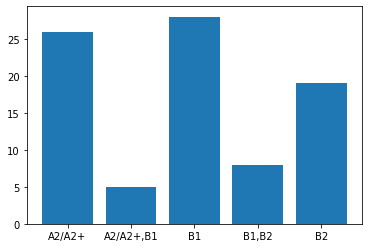

In [52]:
plt.figure()
plt.bar(level_cnts.index ,level_cnts)
plt.show()

*   imballanced target values.  
*   Multiclass or multi labels? ==> multi class
*   would expect the difference between class are small, expecially the classes in middle, e.g. A2/A2+,B1 and B1,B2





## target segmented statistics

In [53]:
# find all numeric columns
num_cols = [col for col in df.columns if df[col].dtype == 'int' or df[col].dtype == 'float']
len(num_cols)

24

In [54]:
grouped_df = df.groupby('level')[num_cols].agg(['mean', 'std']).T

In [55]:
grouped_df

level                                  A2/A2+   A2/A2+,B1          B1  \
sent_len                     mean    5.491923    6.232000    5.730000   
                             std     0.689701    1.122751    0.701517   
sent_len_std                 mean    5.198077    5.750000    5.180714   
                             std     1.249189    1.657785    1.650582   
tok_len                      mean    3.743462    3.826000    3.756429   
                             std     0.091387    0.087920    0.087653   
tok_len_std                  mean    1.870385    2.016000    1.919643   
                             std     0.079974    0.061887    0.072953   
lex_div                      mean    0.191231    0.165400    0.189000   
                             std     0.033519    0.021373    0.029991   
lemma_div                    mean    0.300462    0.265400    0.301107   
                             std     0.048816    0.023330    0.043606   
tree_height                  mean    2.870769    3.044000    2.953214   
                             std     0.203390    0.255206    0.173804   
tree_height_std              mean    1.482308    1.606000    1.509286   
                             std     0.165343    0.110136    0.165304   
max_tree_height              mean   10.923077   11.600000   12.607143   
                             std     2.855494    0.894427    3.909526   
pos_tag_entrophy             mean    0.809500    0.810000    0.813107   
                             std     0.016207    0.006364    0.005050   
fleich_reading_ease          mean   97.016923   95.526000   97.342857   
                             std     2.418442    4.601786    1.691431   
flesch_kincaid_grade         mean    1.600000    1.920000    1.571429   
                             std     0.491528    0.887130    0.409025   
smog_index                   mean    5.996154    6.520000    6.092857   
                             std     0.349263    0.432435    0.273426   
coleman_liau_index           mean    2.863846    3.516000    2.983571   
                             std     0.607085    0.781044    0.599025   
automated_readability_index  mean    2.442308    2.980000    2.525000   
                             std     0.462319    0.653452    0.455115   
dale_chall_readability_score mean    5.358077    5.274000    5.400357   
                             std     0.265812    0.174442    0.220042   
linsear_write_formula        mean   10.575046    4.446320    5.243355   
                             std    18.220750    2.108565    9.484014   
gunning_fog                  mean    3.661923    3.936000    3.722500   
                             std     0.447464    0.395386    0.401586   
fernandez_huerta             mean  126.691923  125.498000  126.917500   
                             std     1.846372    3.529599    1.347227   
szigriszt_pazos              mean  124.145385  121.686000  123.658571   
                             std     1.762950    1.730832    1.637522   
gutierrez_polini             mean   54.633846   53.764000   54.427500   
                             std     0.855944    0.973566    0.795681   
crawford                     mean   -0.350000    0.020000   -0.282143   
                             std     0.343220    0.408656    0.370239   
gulpease_index               mean   86.673077   83.780000   86.435714   
                             std     4.093073    4.931734    4.349561   
osman                        mean   93.055000   90.592000   92.438571   
                             std     2.442966    2.791249    2.311714   

level                                   B1,B2          B2  
sent_len                     mean    6.196250    5.846316  
                             std     0.449410    0.699875  
sent_len_std                 mean    5.133750    5.194737  
                             std     0.597589    1.442407  
tok_len                      mean    3.778750    3.824737  
                             std     0.121236    0.126375  
to

### word count

In [56]:
import seaborn as sns

In [57]:
def hist_plot(x, data=df, figsize=(10, 6), hue='level', bins=30):
  """
  plot the x column histogram while adding another dimension of the target values by coloring 
  """
  plt.figure(figsize = figsize)
  sns.histplot(data = data, x = x, hue='level', bins = bins)
  plt.show()

def scatter_plot(y, x='level', data = df, figsize=(10, 6)):
  """
  plot feature column against level column
  """
  plt.figure(figsize=figsize)
  plt.scatter(x = x, y = y, data = data.sort_values(by='level'))
  plt.ylabel(y)
  plt.show()

def two_plot(col):
  hist_plot(col)
  scatter_plot(col)

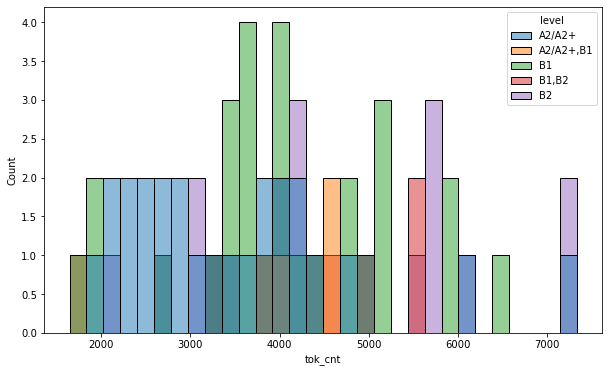

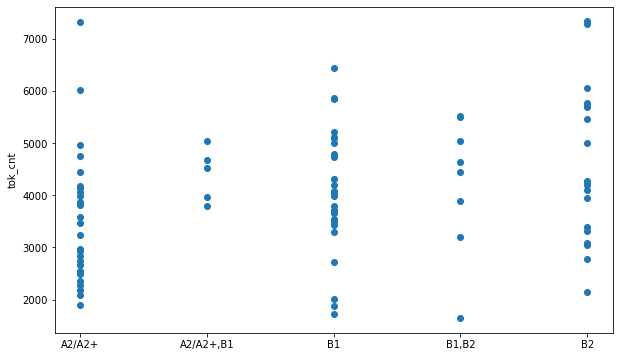

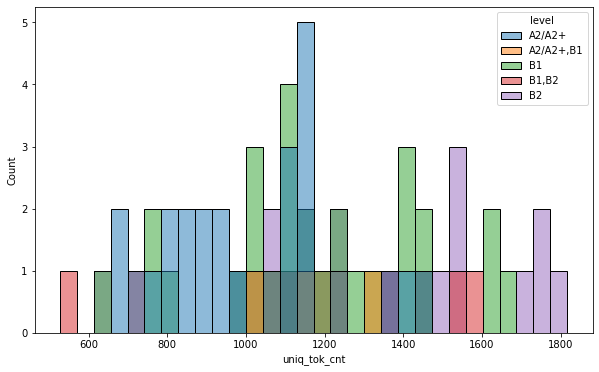

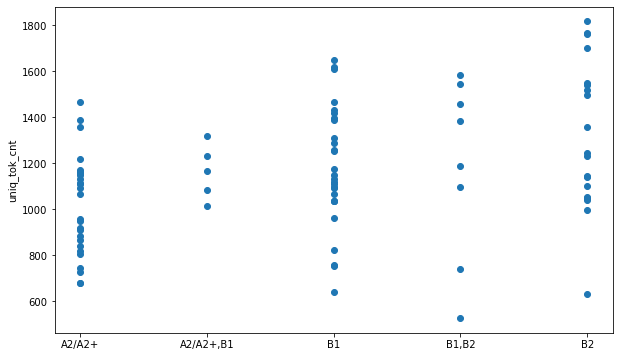

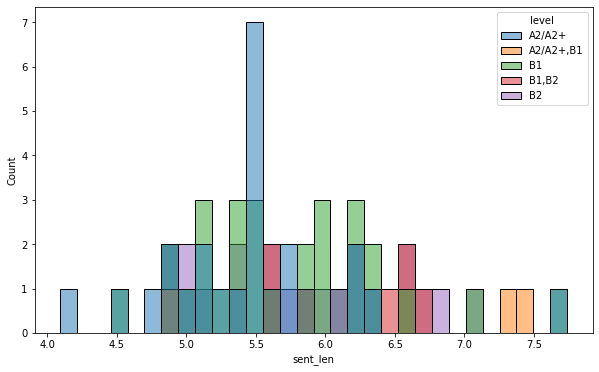

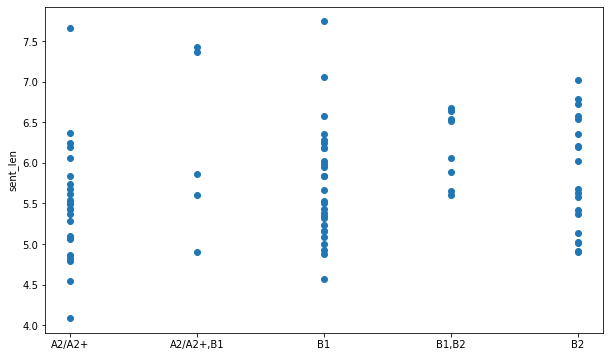

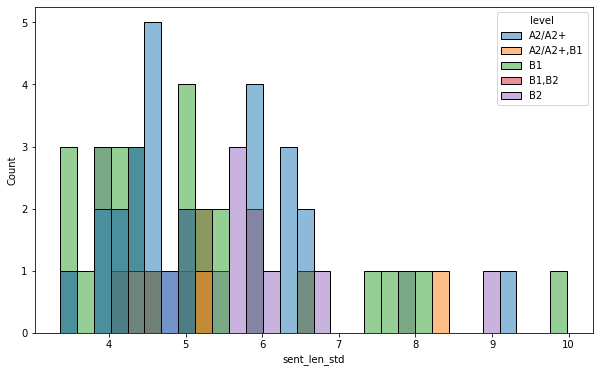

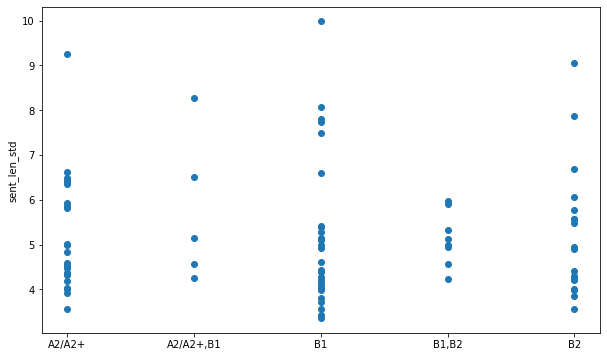

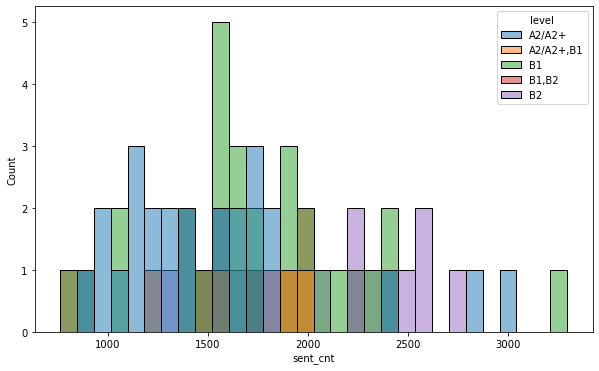

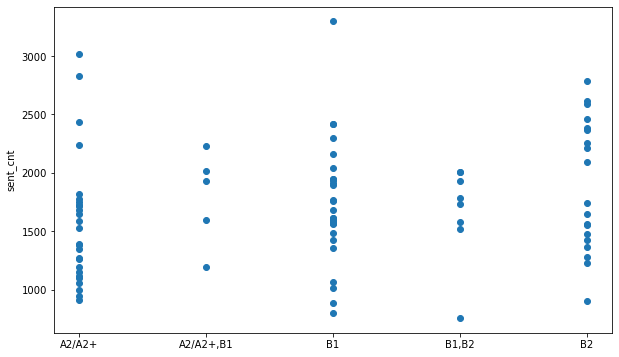

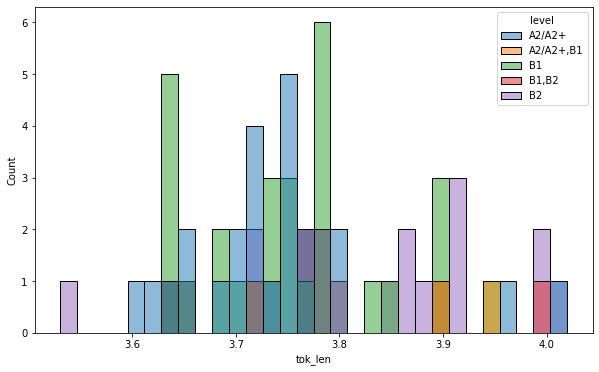

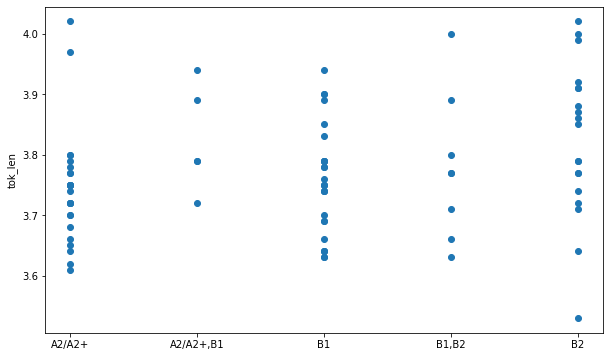

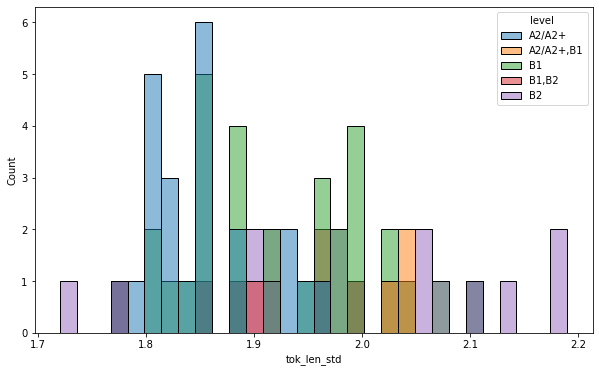

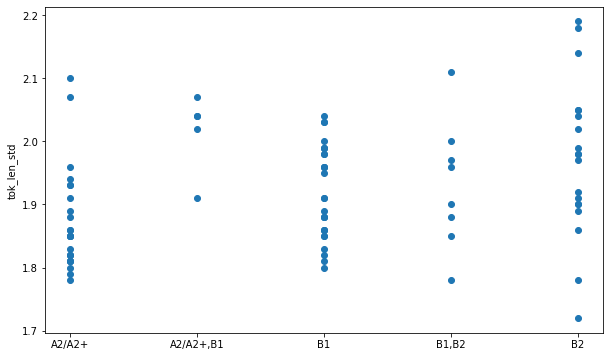

In [58]:
for i in range(3, 10):
  two_plot(df.columns[i])
  print()

**Summary**
- there is a faint correlation with unique word count and the difficulty level


### CEFR word percentages

a1_%


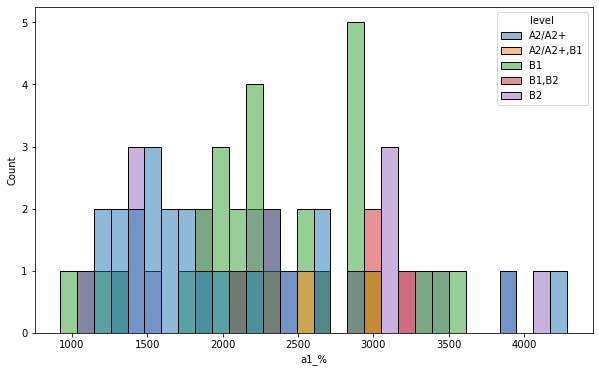

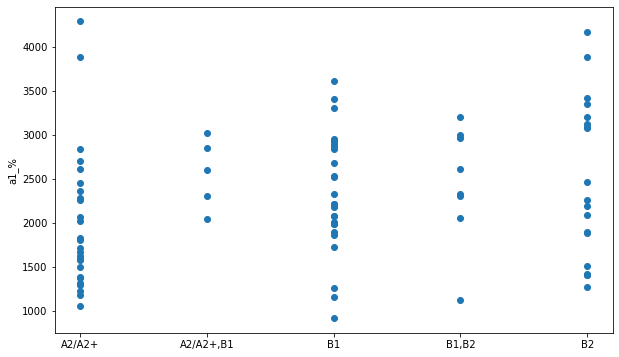

a2_%


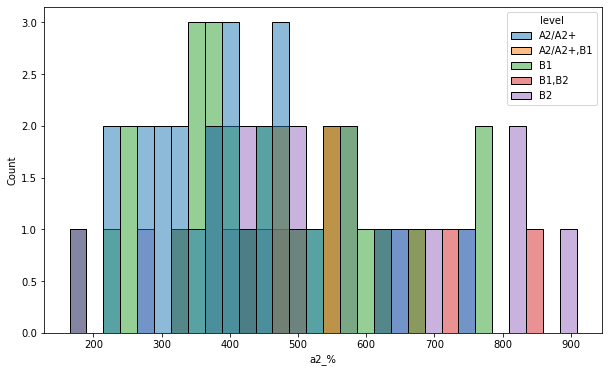

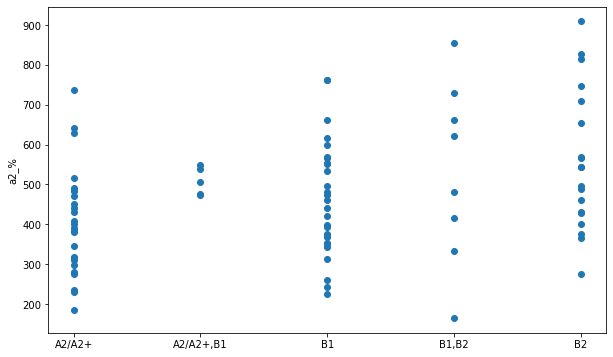

b1_%


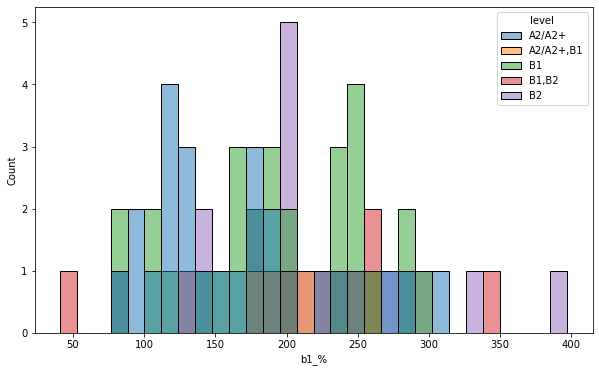

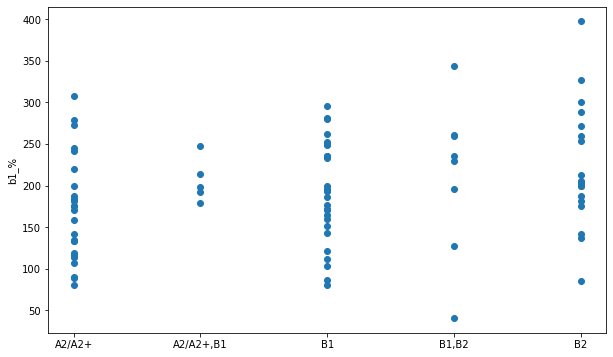

b2_%


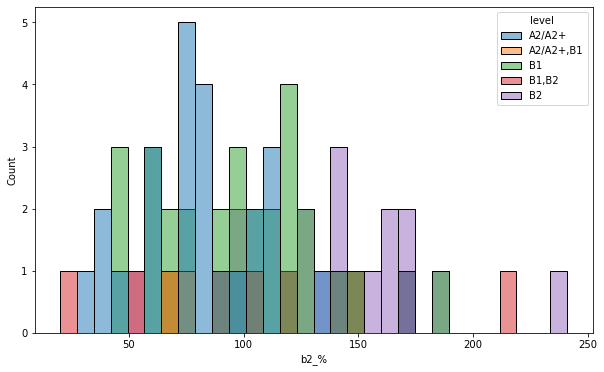

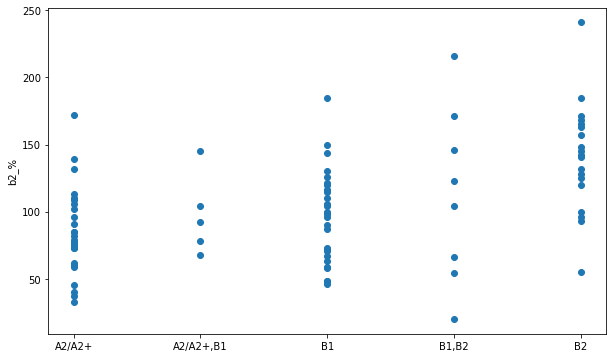

c1_%


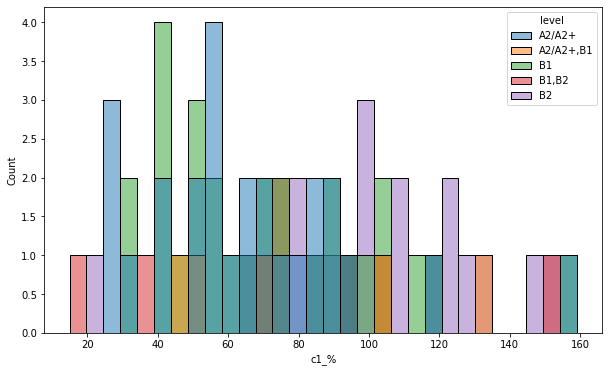

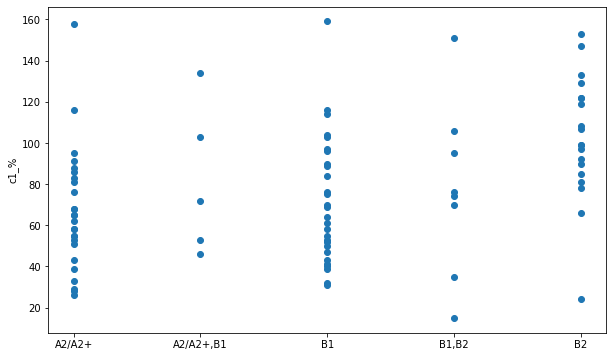

other_%


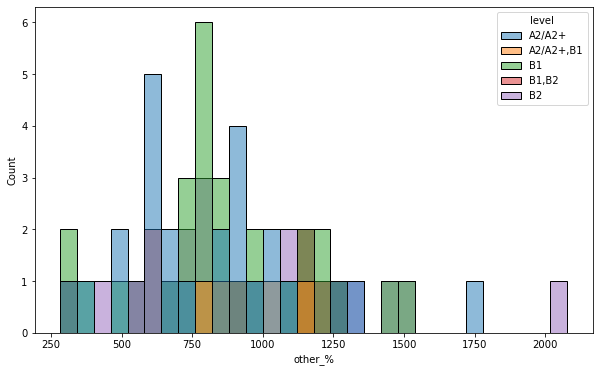

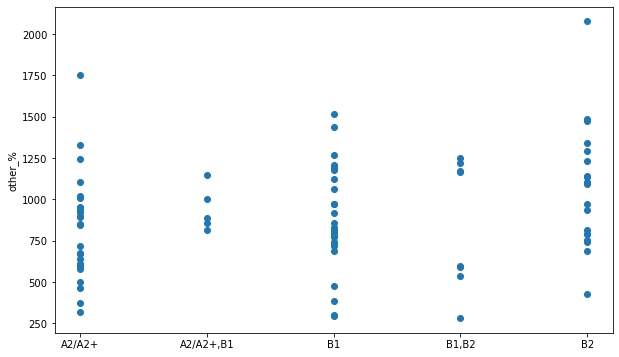

In [59]:
for i in range(10, 16):
  print(df.columns[i])
  two_plot(df.columns[i])

-  majority words are either in the A1 level or outside our vacabulary pool
- within each moive difficulty level, the distribution of the word count is wide and outliers exist
-  only 20 % words are above A1 level
-  no clear correlation with difficulty level, maybe slight correlation

### tree height

tree_height


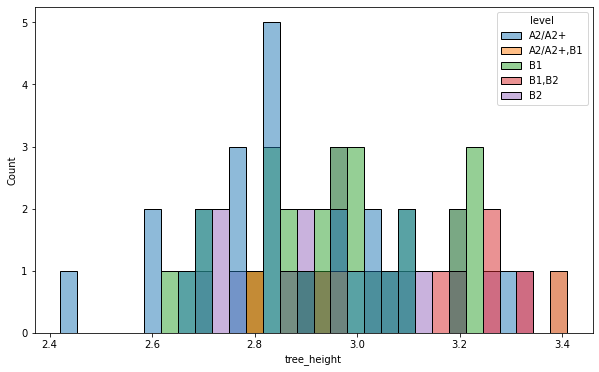

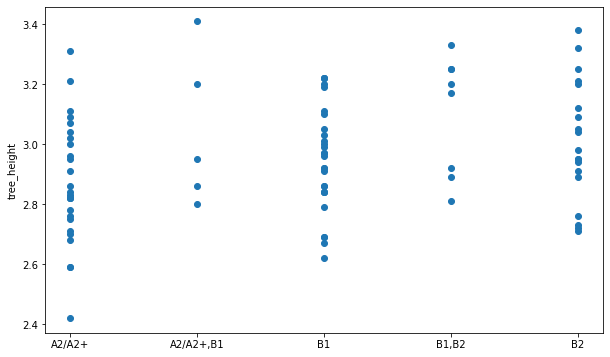

tree_height_std


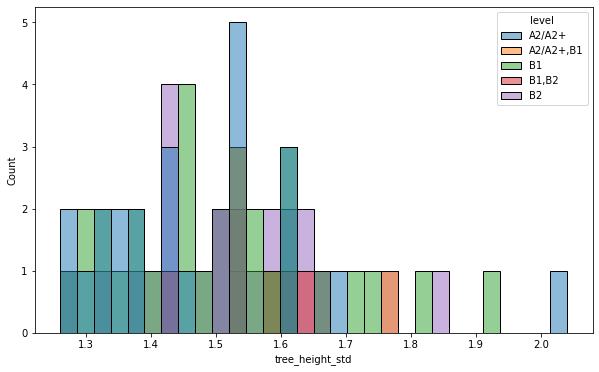

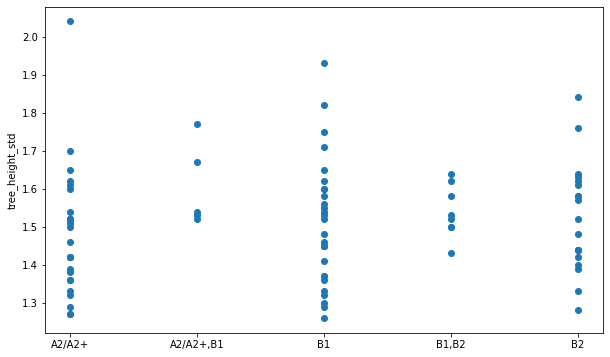

max_tree_height


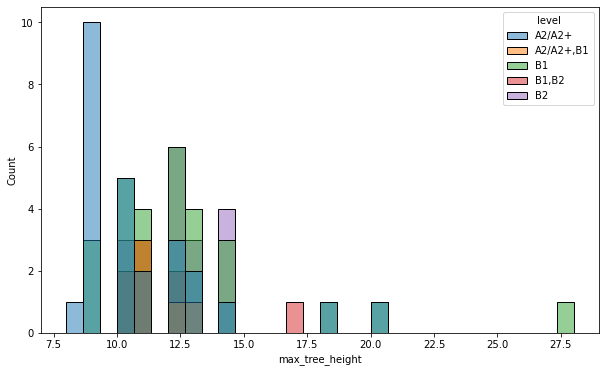

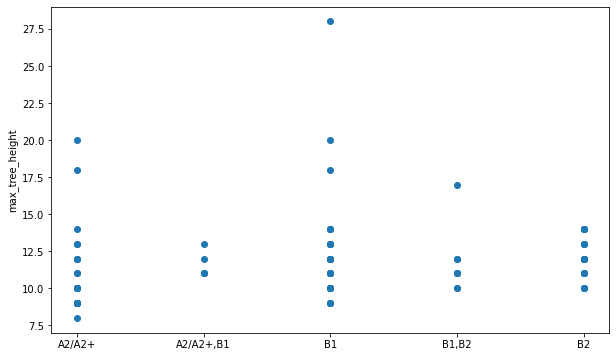

In [60]:
for i in range(19, 22):
  print(df.columns[i])
  two_plot(df.columns[i])

**Summary**
- almost no correlation between tree height and level
- tree height std does not provide too much info

### POS count

UH


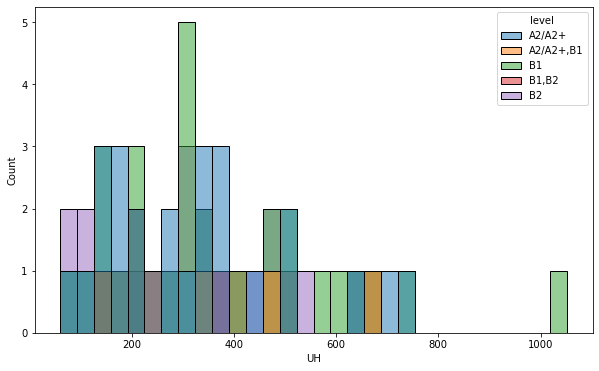

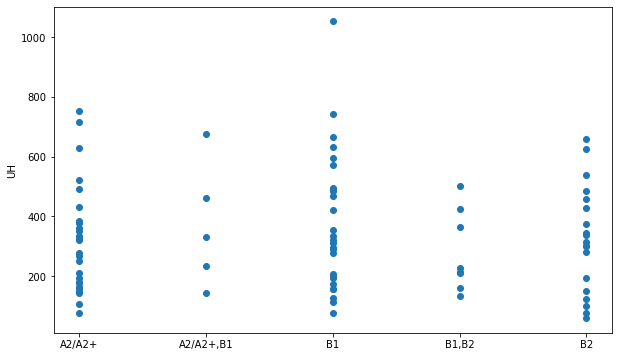

PRP


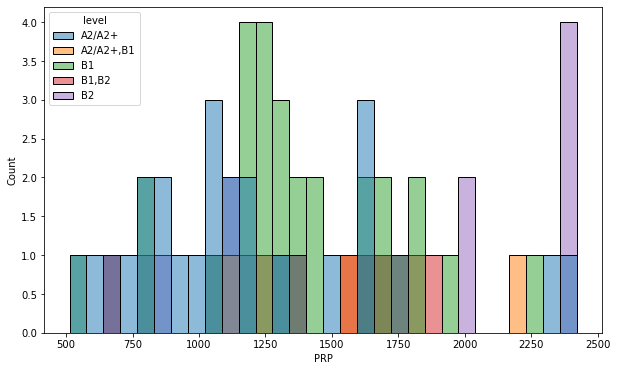

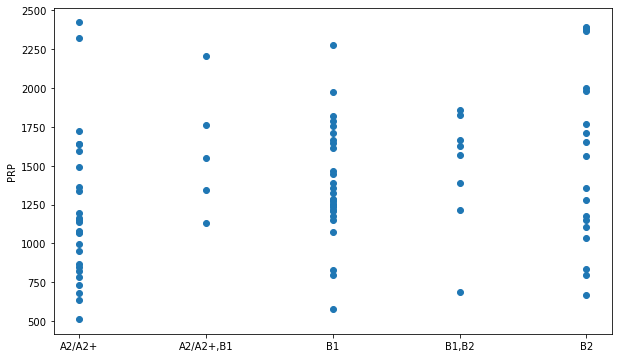

VBP


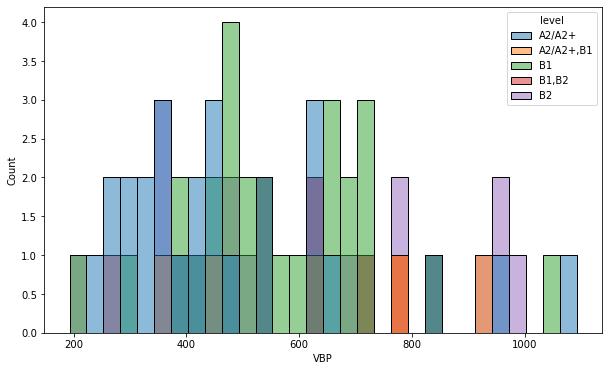

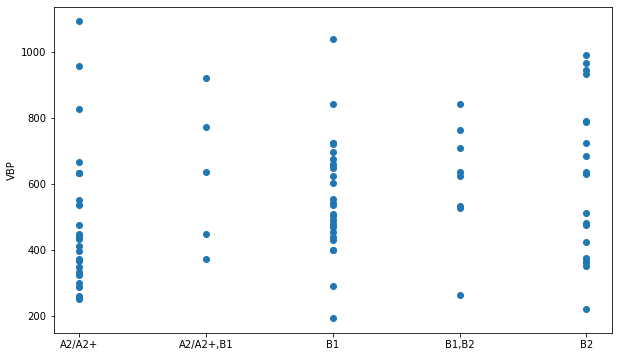

RB


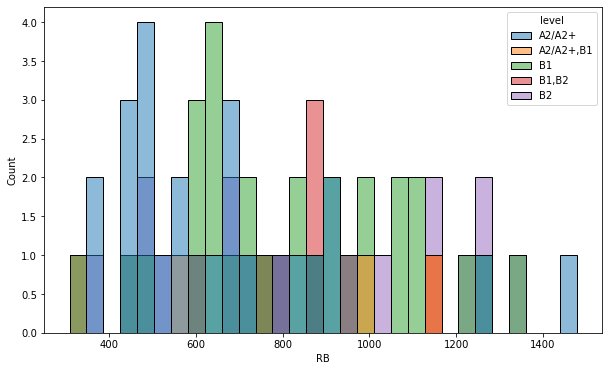

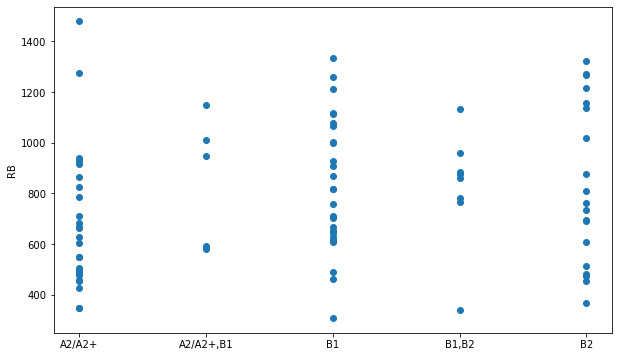

VBG


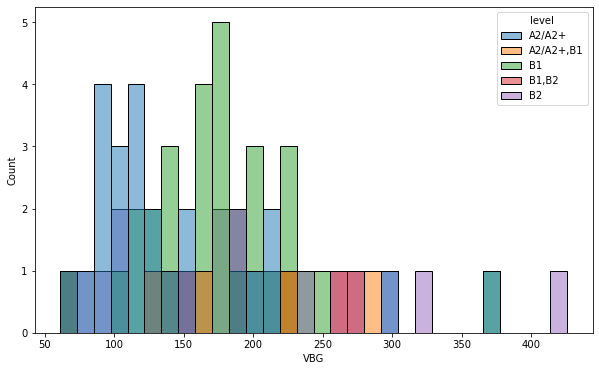

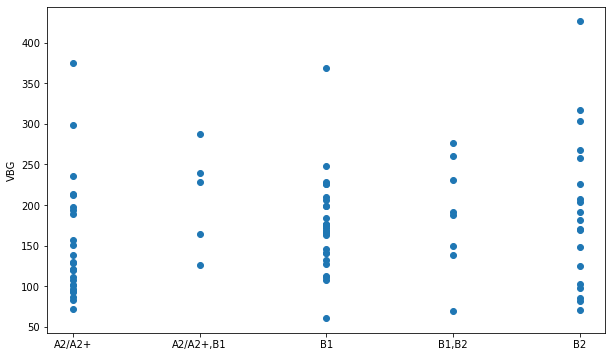

DT


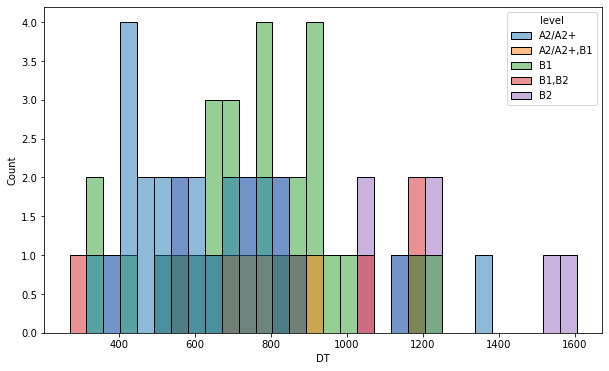

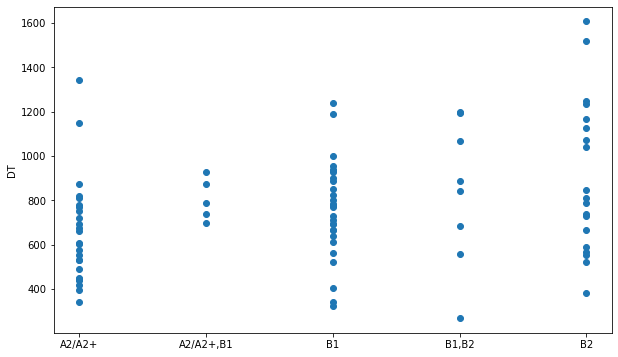

NNP


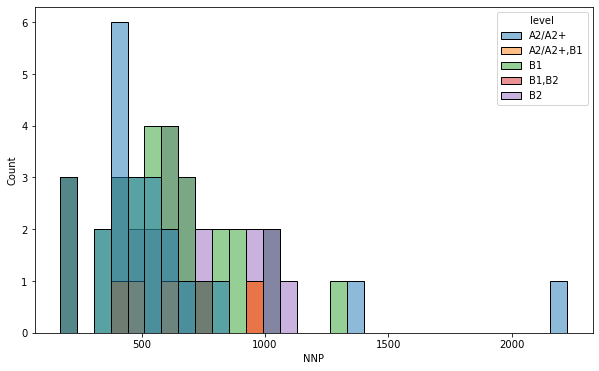

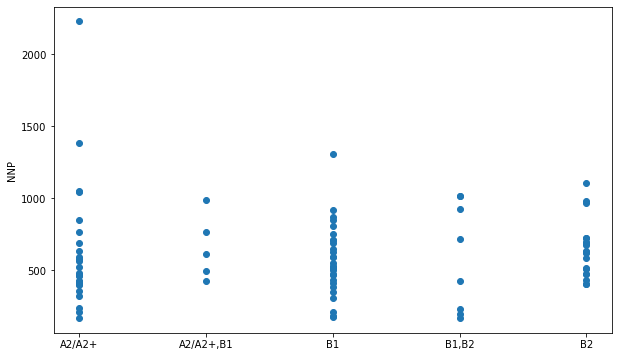

NN


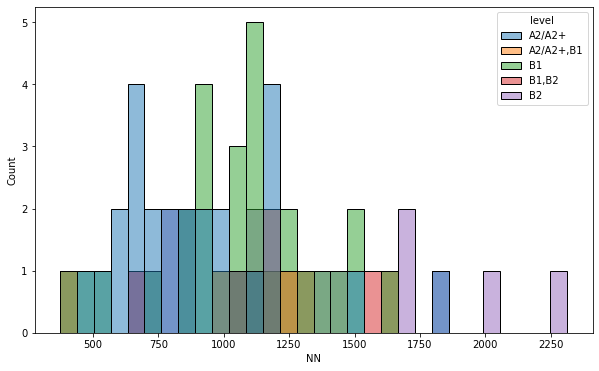

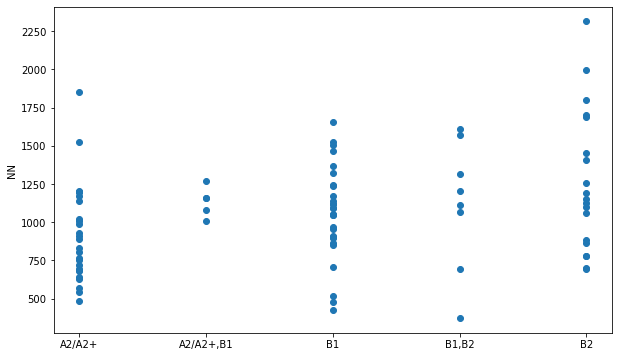

CC


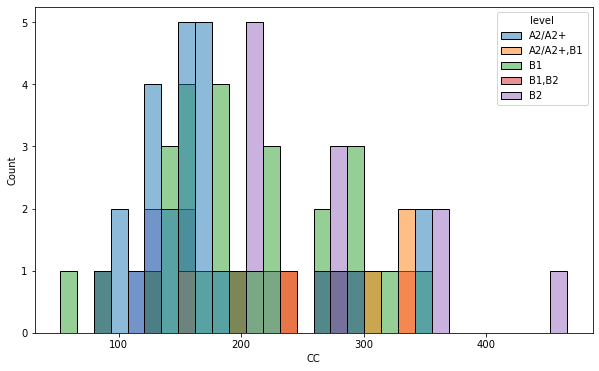

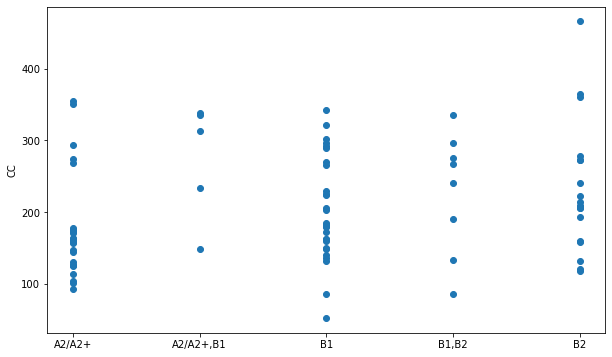

WP


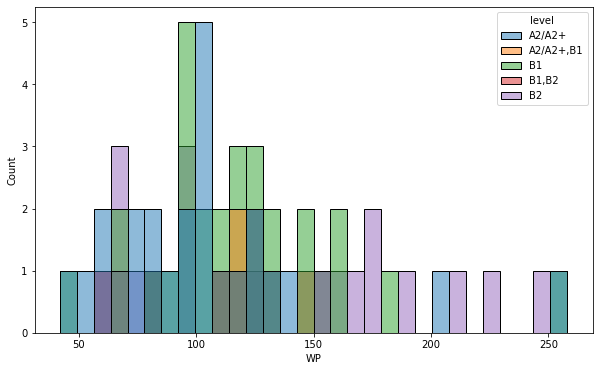

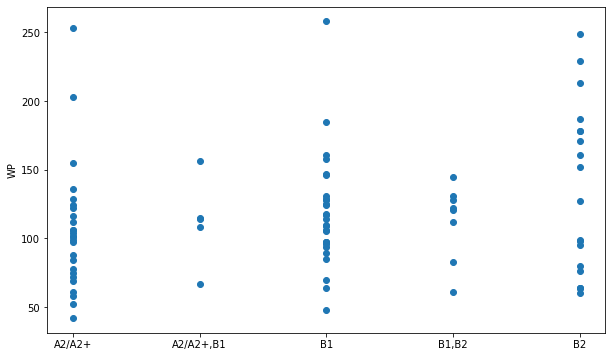

JJ


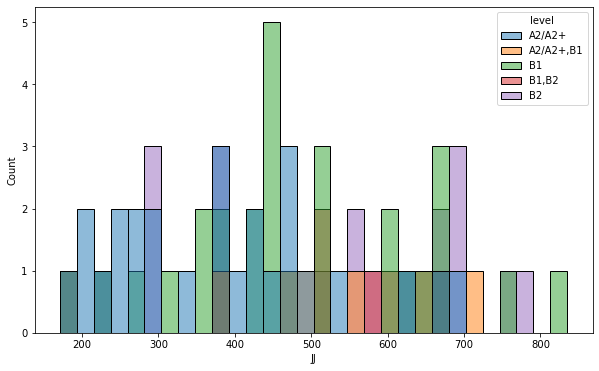

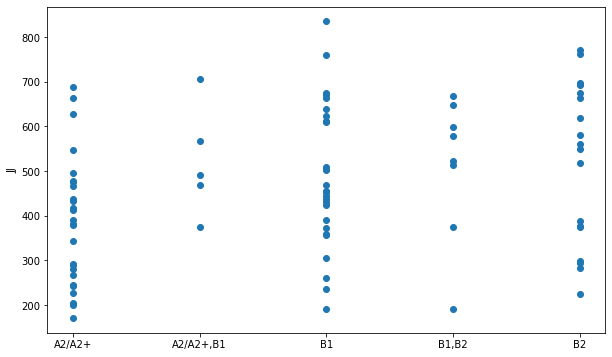

IN


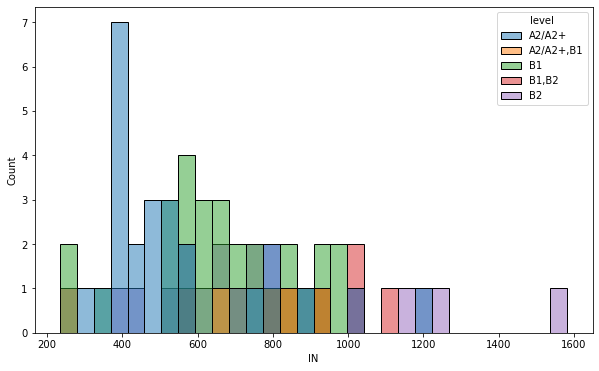

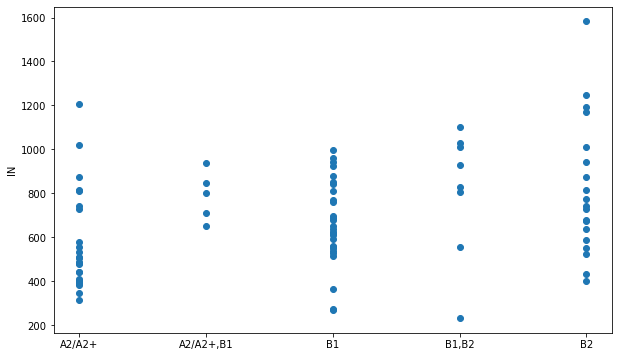

RP


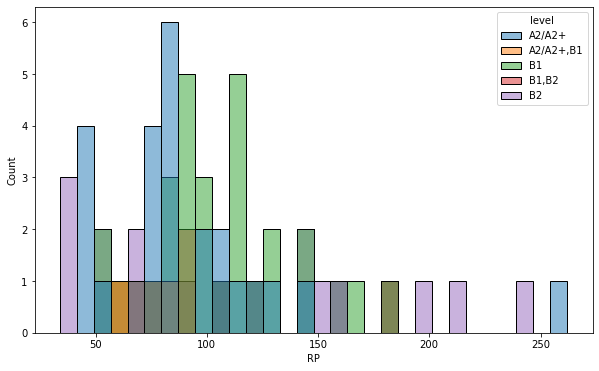

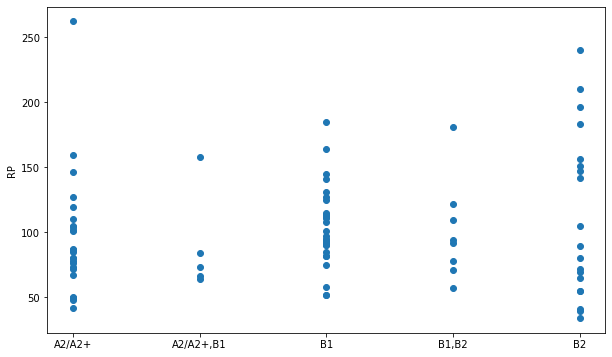

PRP$


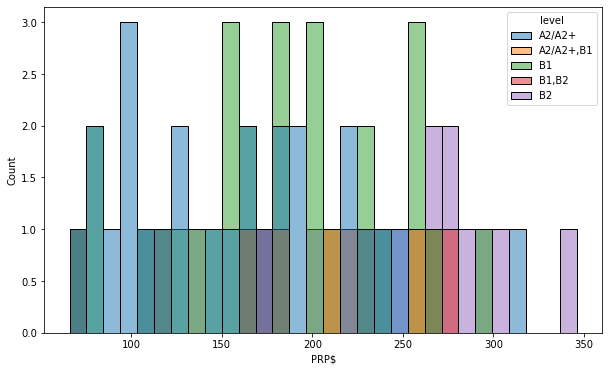

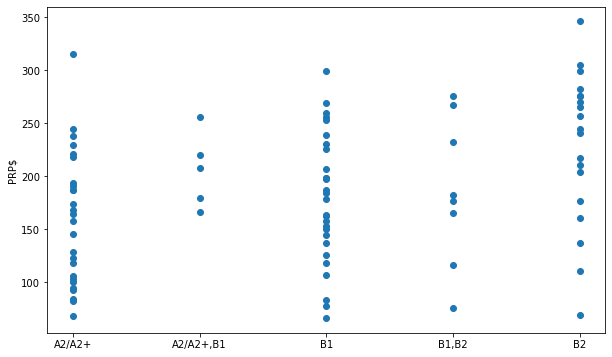

NNS


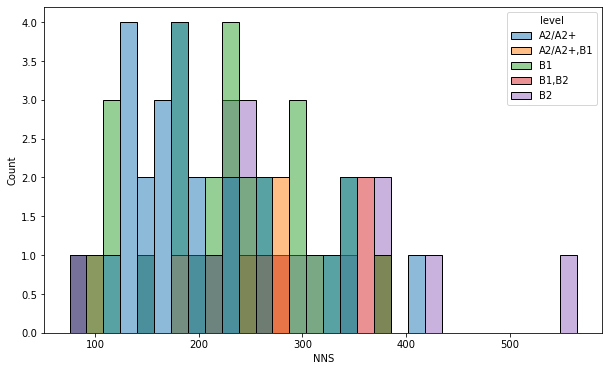

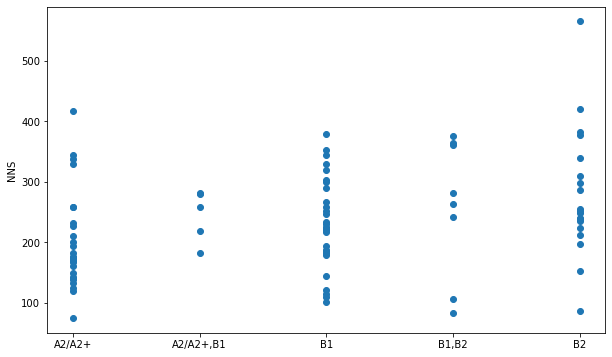

VBZ


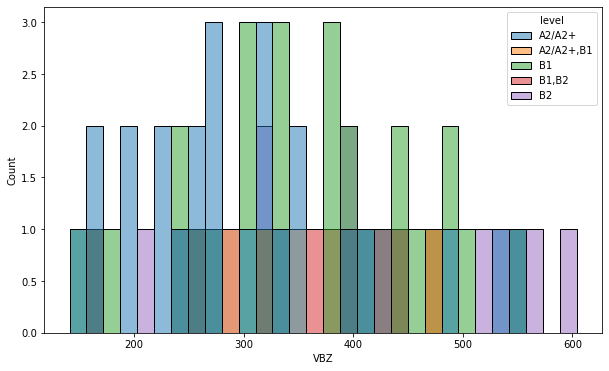

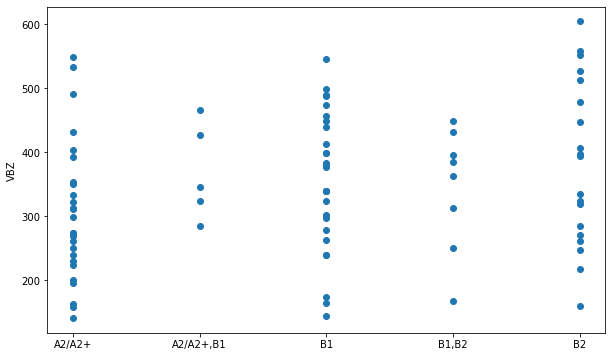

VBN


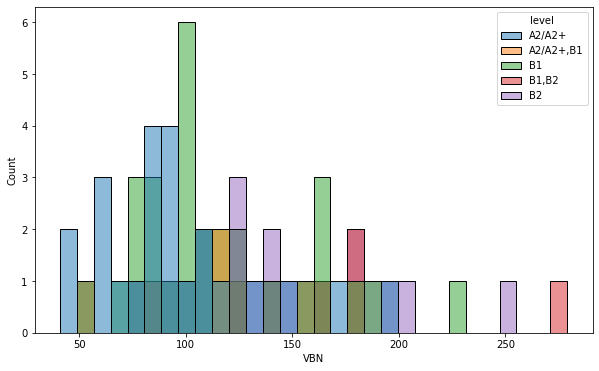

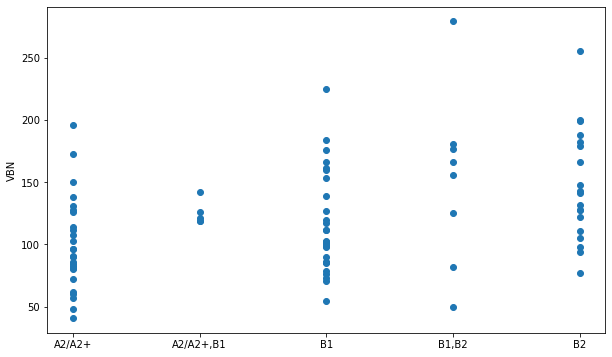

TO


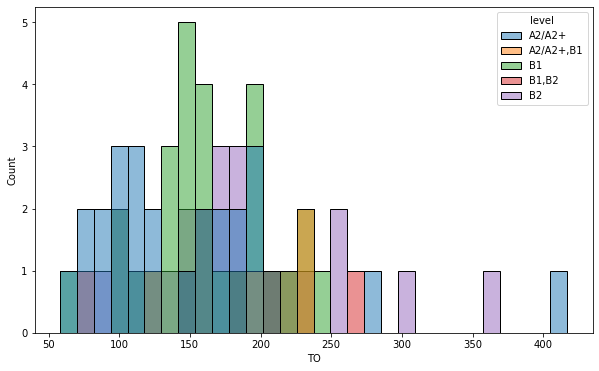

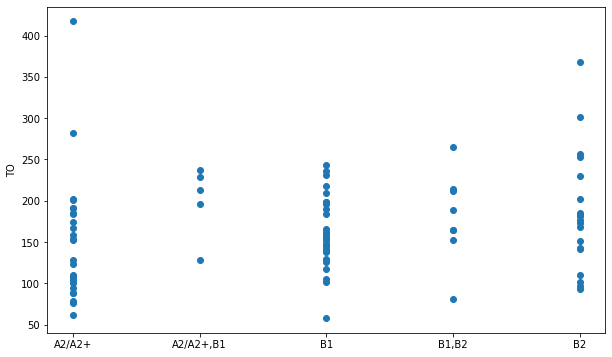

VB


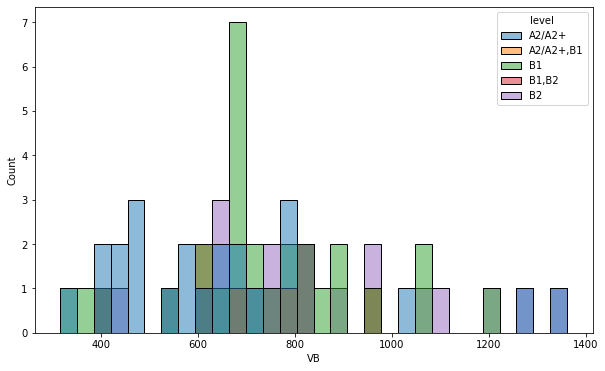

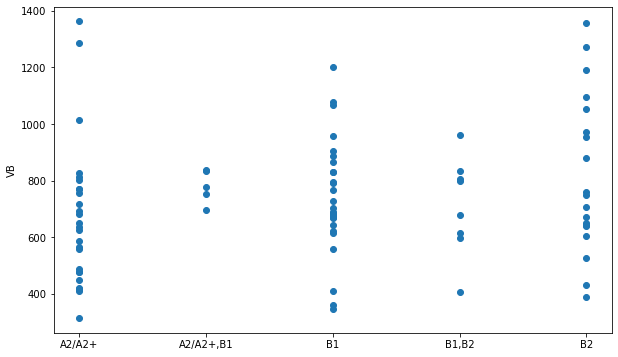

VBD


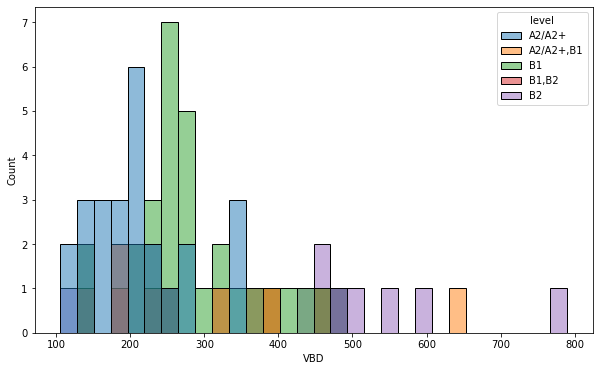

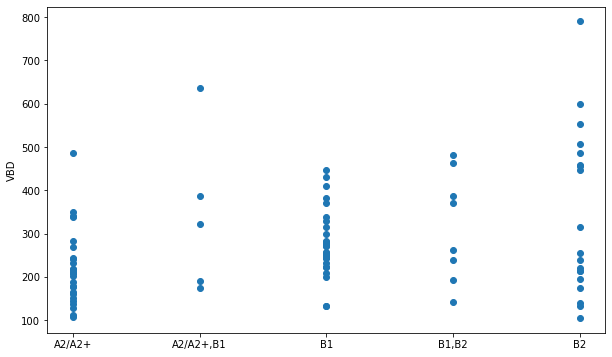

MD


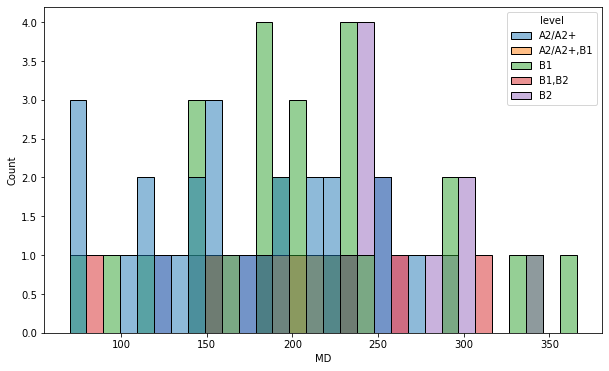

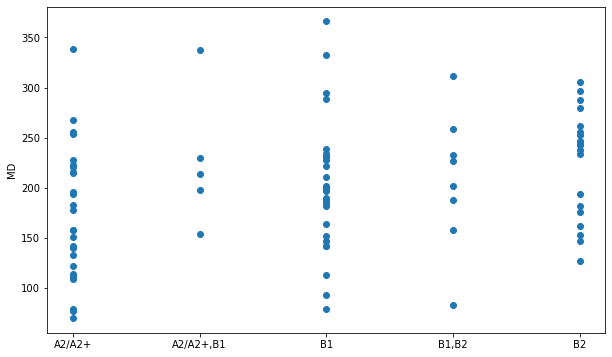

pos_tag_entrophy


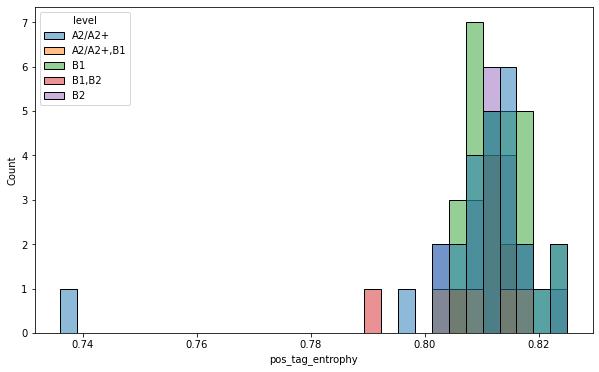

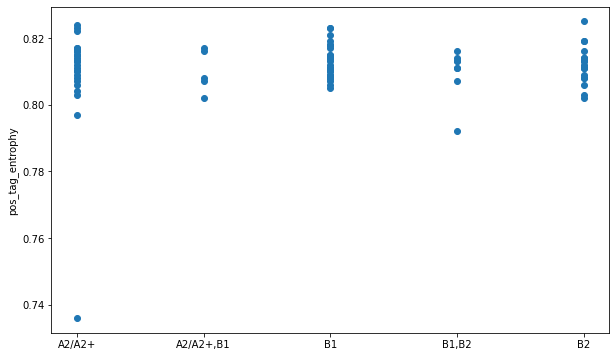

In [61]:
for i in range(22, 44):
  print(df.columns[i])
  two_plot(df.columns[i])

- no clear correlation with the level


### textstats

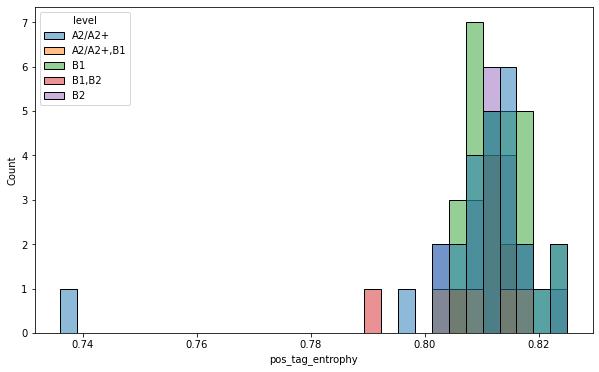

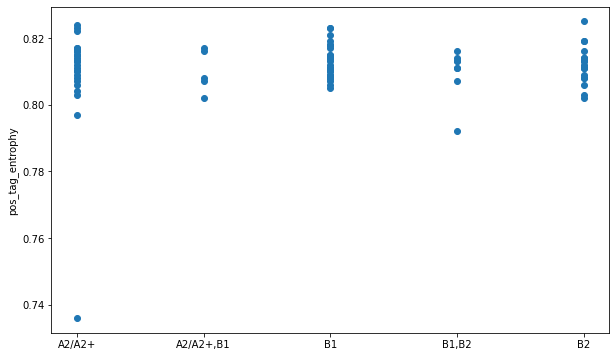

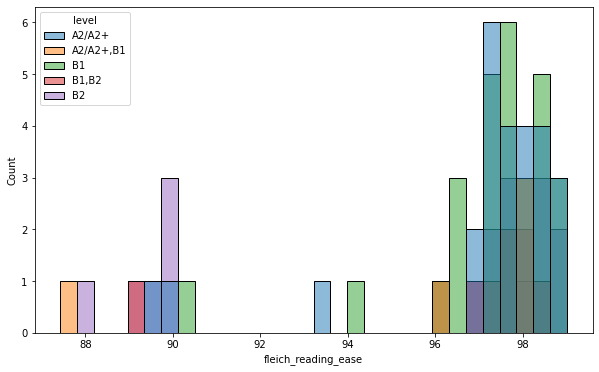

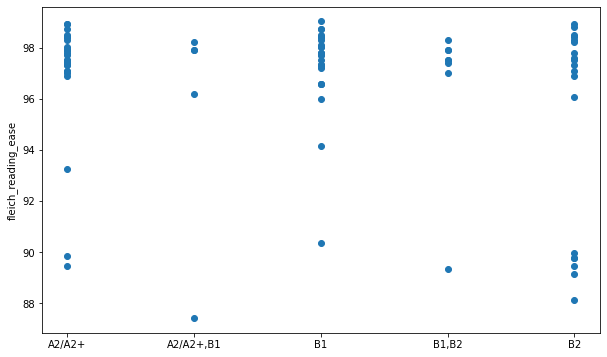

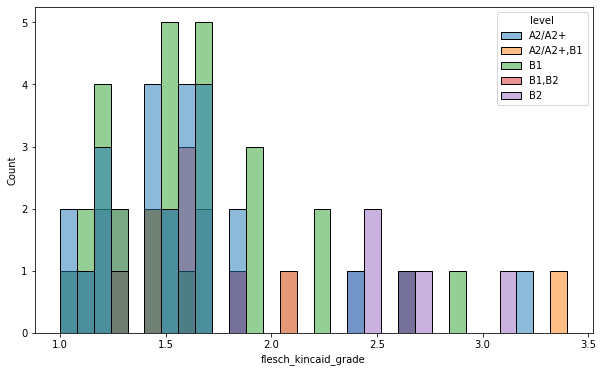

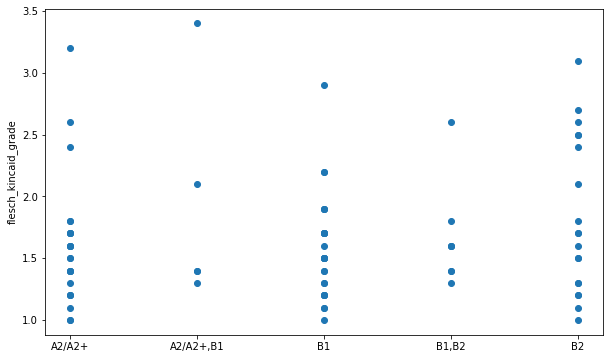

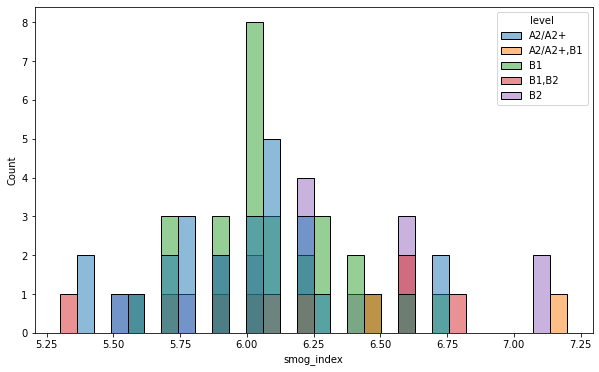

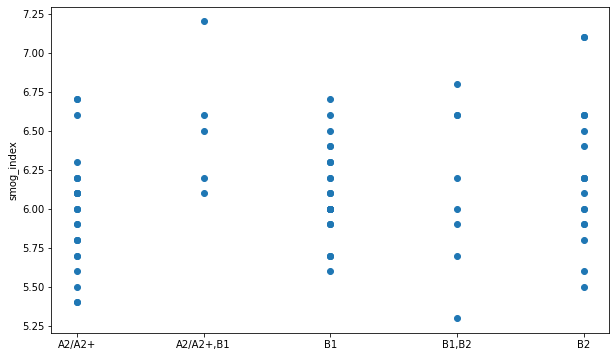

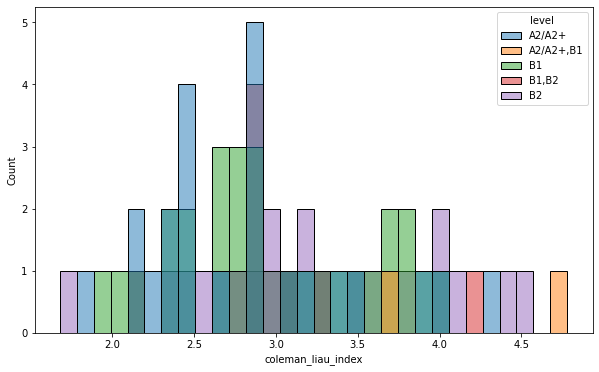

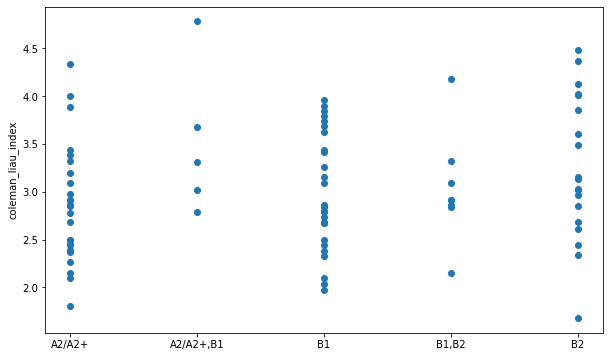

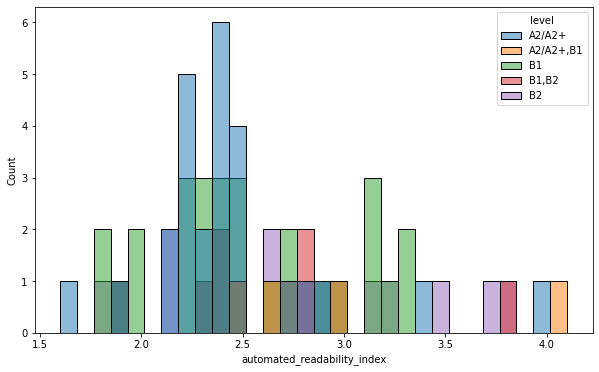

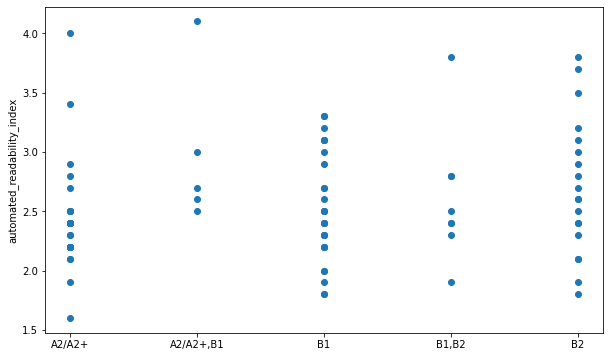

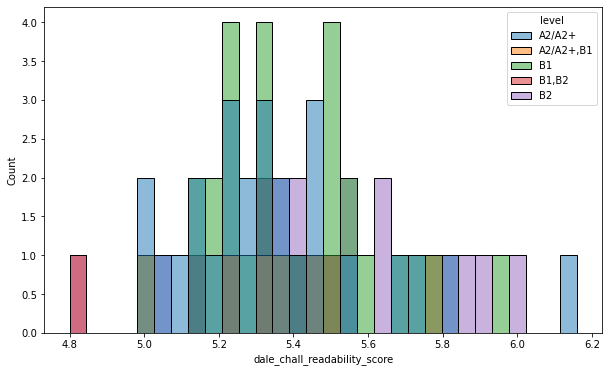

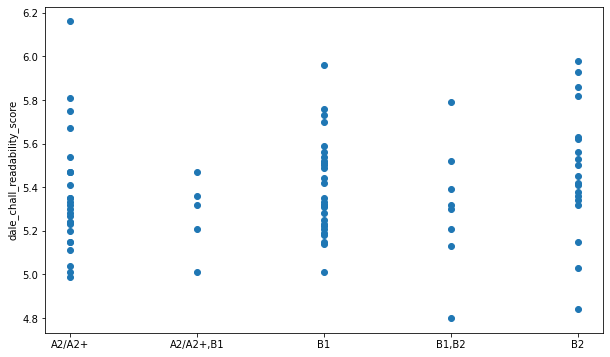

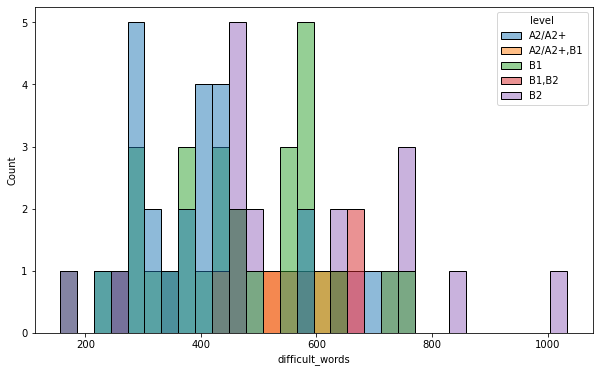

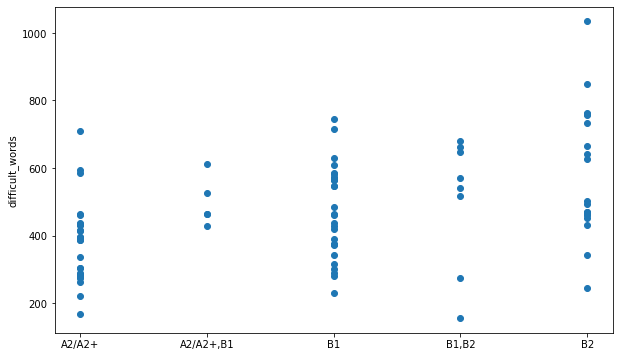

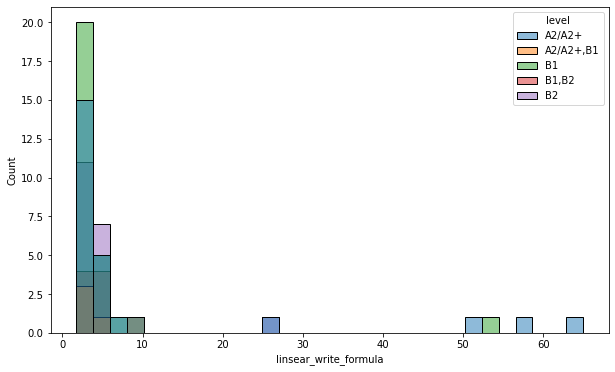

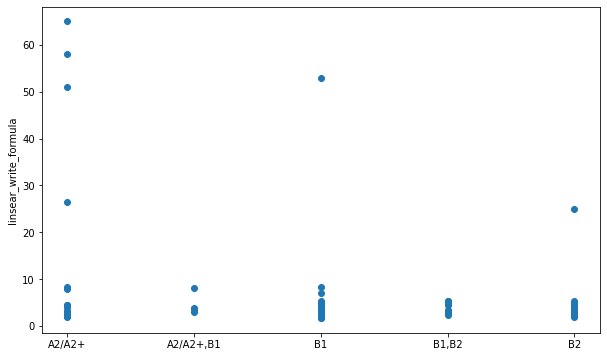

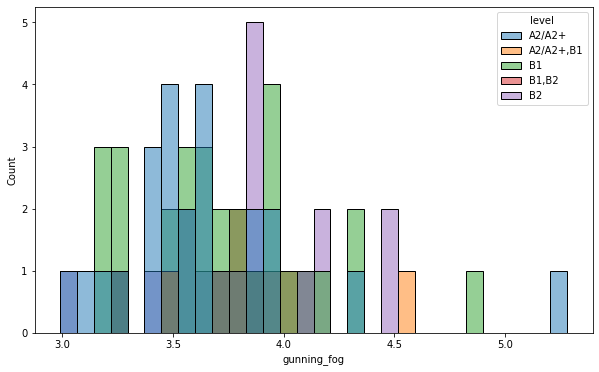

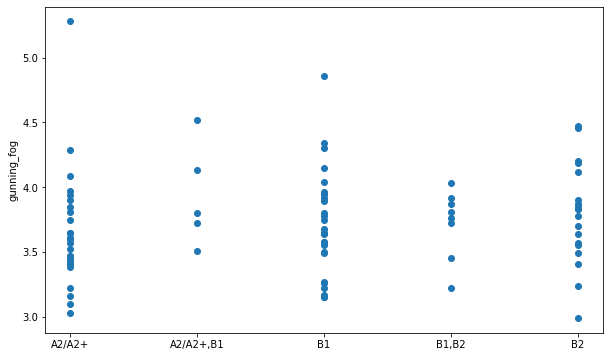

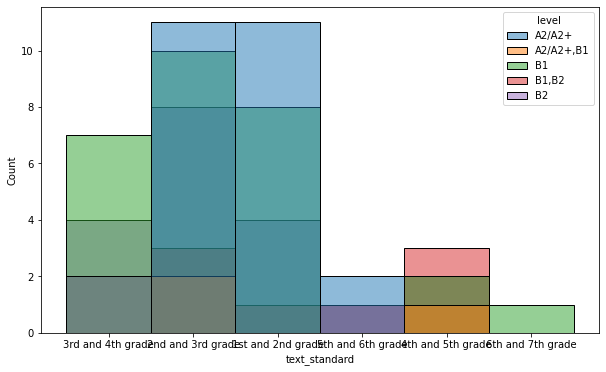

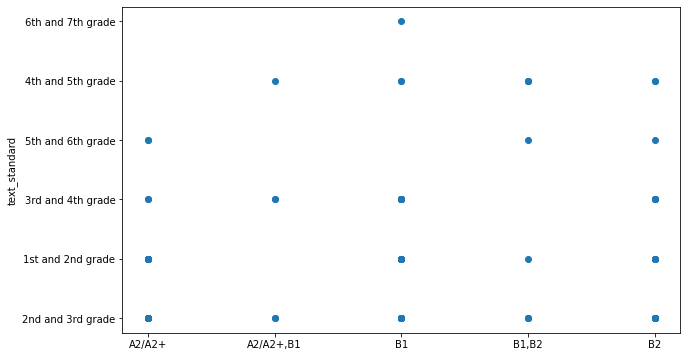

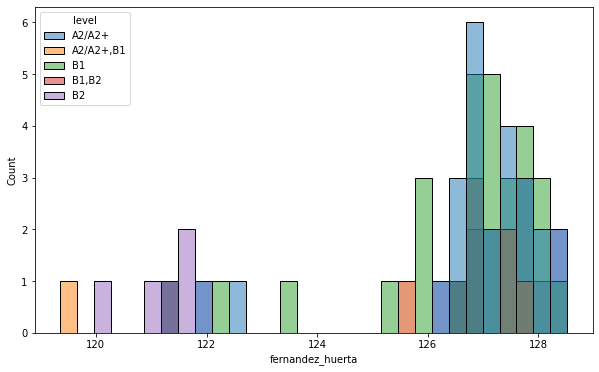

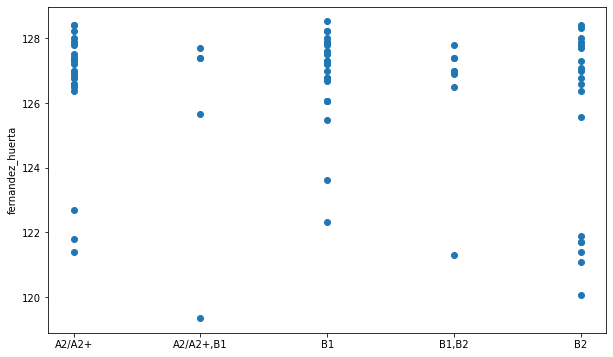

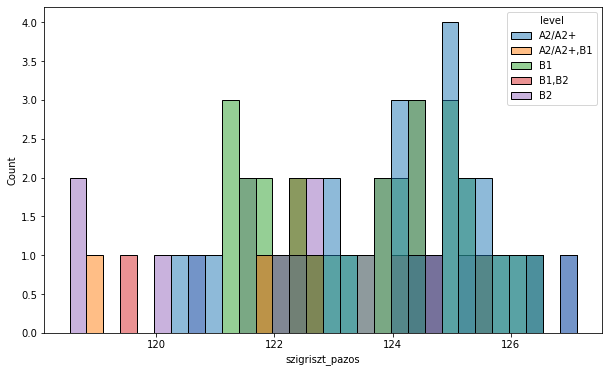

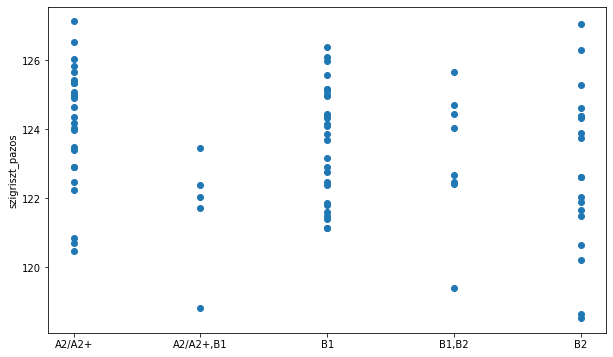

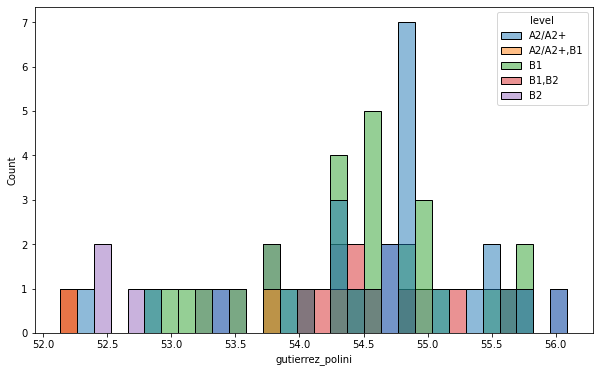

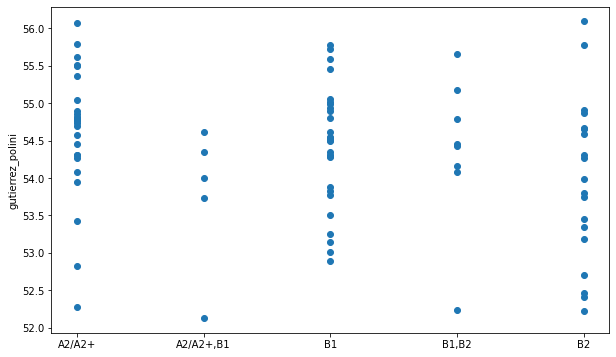

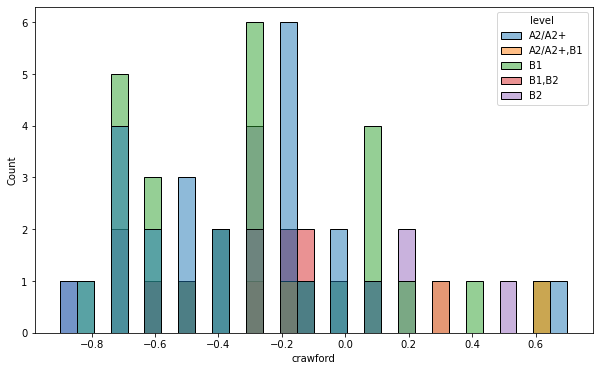

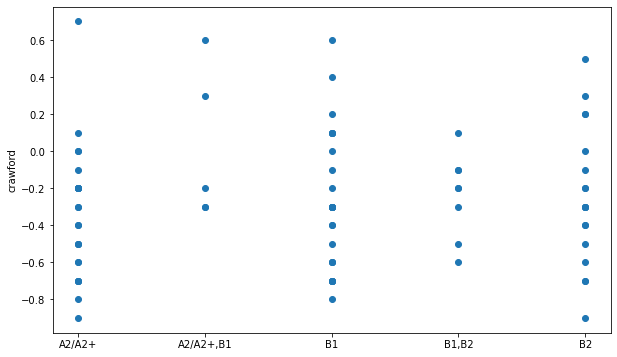

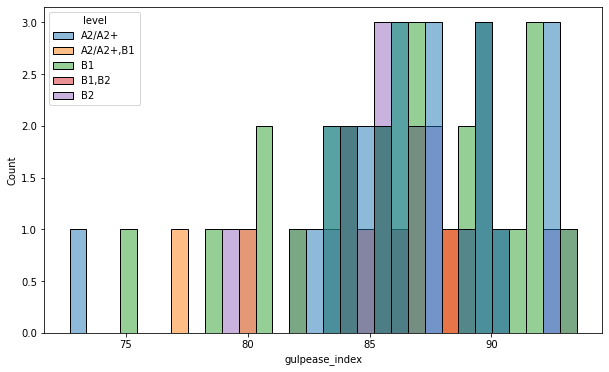

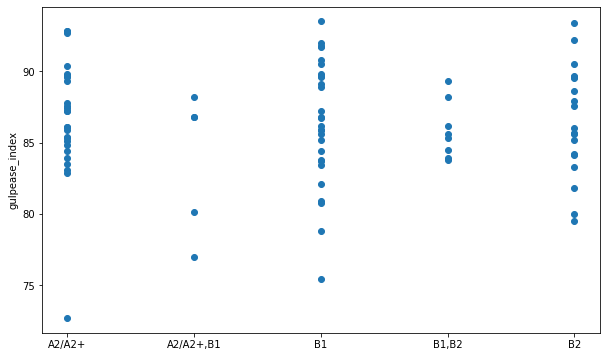

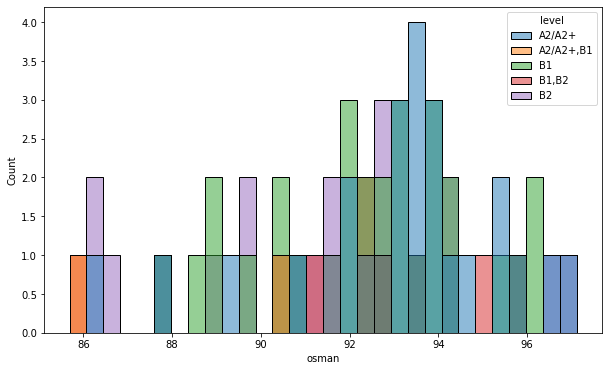

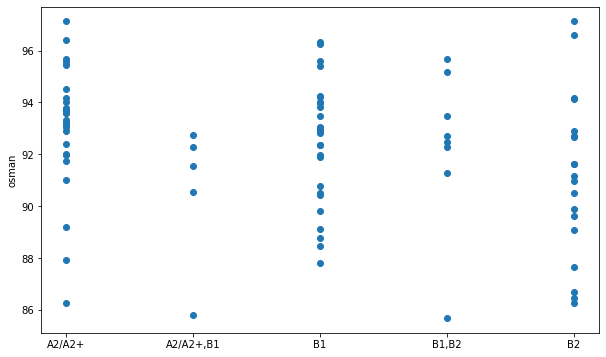

In [62]:
for i in range(43, 60):
  two_plot(df.columns[i])

## the Other subs words

take a look at the tokens which can't be categrozed by ourCEFR dictionary

In [63]:
oxford_words = []
for vocab in vocab_list:
  oxford_words.extend(list(vocab['word']))
len(oxford_words)

4563

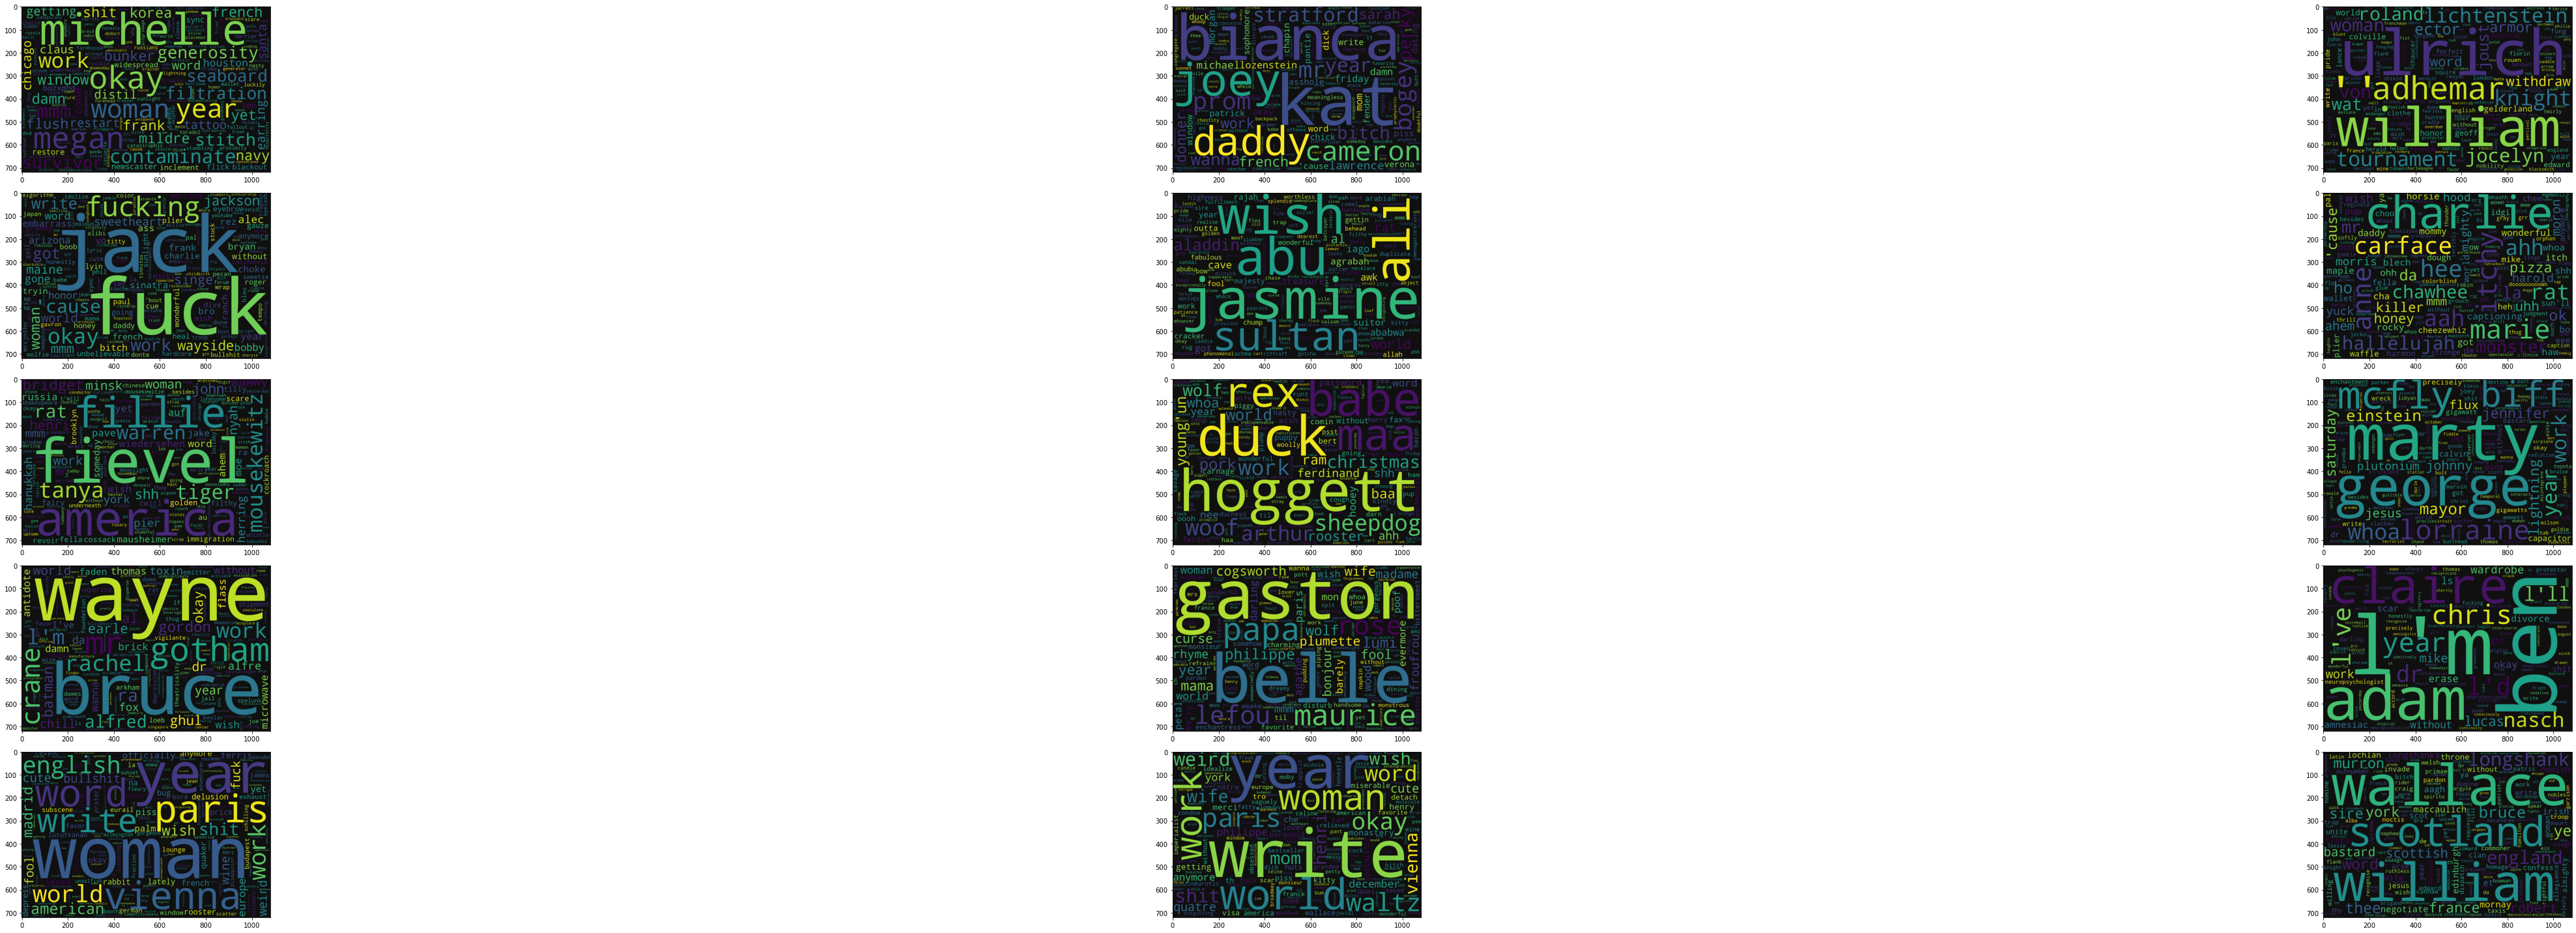

In [64]:
# use wordworld to vissualize the other_word appearance frequnecy
background_color = "#101010"
height = 720
width = 1080
fig, axs = plt.subplots(5, 3, figsize=(90, 20))
for ax, subs in zip(axs.flat ,df.loc[:14,'other_word']):
  other_words_dict = dict()
  for word in subs.split():
    other_words_dict[word] = other_words_dict.get(word, 0) + 1

  word_cloud = WordCloud(background_color=background_color, width=width, height=height)
  word_cloud.generate_from_frequencies(other_words_dict)
  ax.imshow(word_cloud)

plt.tight_layout()
plt.show()

# Modelling

In [65]:
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import seaborn as sns

In [66]:
!pip install statsmodels
!pip install --upgrade --no-deps statsmodels
import statsmodels
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

! pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

features and targets

In [67]:
# features and targets
X = df.drop(columns = ['level', 'text_standard', 'title', 'subs', 'subs_lemma', 'other_word'])
#X = df[['uniq_tok_cnt', 'difficult_words']]
y = df['level']

split data to training and testing, stratify = y

In [68]:
# split data to training and testing, stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12345, stratify=y)
print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')
print()
print('Target values of training samples')
print(y_train.value_counts())
print()
print('Target values of testing samples')
print(y_test.value_counts())

Training samples: 73
Testing samples: 13

Target values of training samples
B1           24
A2/A2+       22
B2           16
B1,B2         7
A2/A2+,B1     4
Name: level, dtype: int64

Target values of testing samples
A2/A2+       4
B1           4
B2           3
A2/A2+,B1    1
B1,B2        1
Name: level, dtype: int64


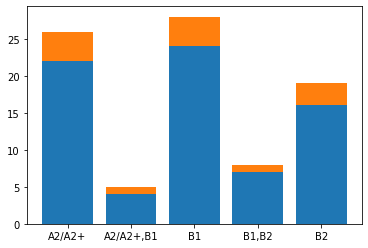

In [69]:
train_cnt = y_train.value_counts()[level_names]
test_cnt = y_test.value_counts()[level_names]
fig, ax = plt.subplots()
ax.bar(train_cnt.index, train_cnt)
ax.bar(test_cnt.index, test_cnt, bottom=train_cnt)
plt.show()

define function to   
- tune hyper parameters of selected model with weighted F1 as score   
- return tuned hyper parameters


In [70]:
def tune_hyper(model, param_grid, X, y, standard=True):
  """
  tune hyper parameters of selected model with weighted F1 as score
  return tuned hyper parameters
  """

  if standard:
    scaler = StandardScaler()
    pipeline = Pipeline(steps=[("scaler", scaler), ("clf", model)])
    grid = GridSearchCV(pipeline, param_grid = param_grid, refit=True, cv=10, scoring='f1_weighted')
  else:
    grid = GridSearchCV(model, param_grid = param_grid, refit=True, cv=10, scoring='f1_weighted')
  grid.fit(X, y)
  print(f'best weighted F1: {grid.best_score_} with {grid.best_params_} ')

  new_dic = {}
  for key in grid.best_params_.keys():
    value = grid.best_params_[key]
    key = re.sub(r'clf__', '', key)
    new_dic[key] = value
  return new_dic

define function to   
- split training datasets with statified k fold  
- cross validate a fine tuned model on each folds  
- print model's accuracys f1 score for each fold as well as the mean scores



In [71]:
def cross_validation(model, X, y, cv=10, standard=True):
  """
  split training datasets with statified k fold
  cross validate a fine tuned model on each folds
  print model's accuracys f1 score for each fold as well as the mean scores
  """

  skf = StratifiedKFold(n_splits=cv)
  train_accuracys = []
  train_fscores = []
  test_accuracys = []
  test_fscores = []
  fold = 1
  for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    if standard:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    predict_train = model.predict(X_train)
    # print(f'fold: {fold}')
    # train_cnt = y_train.value_counts()[level_names]
    # test_cnt = y_test.value_counts()[level_names]
    # fig, ax = plt.subplots()
    # ax.bar(train_cnt.index, train_cnt)
    # ax.bar(test_cnt.index, test_cnt, bottom=train_cnt)
    # plt.show()
    train_accuracys.append(accuracy_score(y_train, predict_train))
    train_fscores.append(score(y_train, predict_train, average='weighted')[2])
    test_accuracys.append(accuracy_score(y_test, predict))
    test_fscores.append(score(y_test, predict, average='weighted')[2])
    fold += 1

  print('For training')
  print(f'accuracys: {[round(num, 2) for num in train_accuracys]}, Mean accuray: {np.mean(train_accuracys):.2f} ')
  print(f'fscores: {[round(num, 2) for num in train_fscores]}, Mean fscores: {np.mean(train_fscores):.2f} ')
  print()
  print('For testing')
  print(f'accuracys: {[round(num, 2) for num in test_accuracys]}, Mean accuray: {np.mean(test_accuracys):.2f} ')
  print(f'fscores: {[round(num, 2) for num in test_fscores]}, Mean fscores: {np.mean(test_fscores):.2f} ')
    

In [72]:
def perm_import(model, X_train, y_train, X_test, y_test, metric='train', threshold=0.01):
  scaler = StandardScaler()
  X_train_std = scaler.fit_transform(X_train)
  X_test_std = scaler.transform(X_test)
  model.fit(X_train_std, y_train)
  if metric == 'train':
    perm = PermutationImportance(model, random_state=12345, scoring='f1_weighted')
    perm.fit(X_train_std, y_train)
  else:
    perm = PermutationImportance(model, random_state=12345, scoring='f1_weighted')
    perm.fit(X_test_std, y_test)
  
  display(eli5.show_weights(perm, feature_names = X.columns.tolist()))
  sel_features_index = np.argwhere(perm.feature_importances_ > threshold)
  sel_features = X.columns[sel_features_index]

  return sel_features.reshape(-1,).tolist()

In [125]:
def eval_model(model, X_train, y_train, X_test, y_test):

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # score dataframe
  score_dic = {}
  labels = level_names
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  precision, recall, fscore, support = score(y_test, predict, labels = labels)
  average = pd.Series(score(y_test, predict, 
                  labels = labels, 
                  average = 'weighted'), name='weighted_avg',
                  index = ['precision', 'recall', 'fscore', 'support'])
  score_dic['precision'] = precision
  score_dic['recall'] = recall
  score_dic['fscore'] = fscore
  score_dic['support'] = support
  score_df = pd.DataFrame.from_dict(score_dic, orient='index', columns=labels)
  score_df = score_df.join(average)

  # confusion matrix
  cm = confusion_matrix(y_test, predict, labels = labels)
  cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  print()
  print(f'Accuracy score: {accuracy_score(y_test, predict):.2f}')
  print()

  return score_df

## SVM

### Tune hyperparameters via cross validation

In [74]:
svc_clf = SVC(degree=3, random_state=12345)
svc_params = {
   'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
   'clf__C': np.arange(1, 21, 0.2),
   'clf__gamma': ['scale', 'auto'] 
}
svc_best = tune_hyper(svc_clf, svc_params, X_train, y_train)

best weighted F1: 0.43823979591836737 with {'clf__C': 2.5999999999999996, 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid'} 


### cross validaton again with fined tuned parameter

In [75]:
svc_clf = SVC(**svc_best, degree=3, random_state=12345)
cross_validation(svc_clf, X_train, y_train)

For training
accuracys: [0.43, 0.48, 0.4, 0.56, 0.56, 0.47, 0.5, 0.56, 0.48, 0.45], Mean accuray: 0.49 
fscores: [0.4, 0.44, 0.37, 0.54, 0.52, 0.42, 0.46, 0.51, 0.45, 0.41], Mean fscores: 0.45 

For testing
accuracys: [0.5, 0.88, 0.62, 0.57, 0.29, 0.43, 0.29, 0.29, 0.57, 0.57], Mean accuray: 0.50 
fscores: [0.44, 0.83, 0.53, 0.56, 0.26, 0.34, 0.16, 0.21, 0.53, 0.51], Mean fscores: 0.44 


### Feature importance 

- features which increase the metrics more than 0.01

In [76]:
svc_clf = SVC(**svc_best, degree=3, random_state=12345)
svc_features = perm_import(svc_clf, X_train, y_train, X_test, y_test, metric='train', threshold = 0.01)
svc_features

['sent_len',
 'b2_%',
 'c1_%',
 'tree_height_std',
 'RB',
 'NNP',
 'NN',
 'PRP$',
 'NNS',
 'VBD',
 'smog_index',
 'coleman_liau_index',
 'automated_readability_index',
 'linsear_write_formula',
 'fernandez_huerta',
 'szigriszt_pazos']

## Logistic Regression

### Tune hyperparameters via cross validation

In [77]:
lr_clf = LogisticRegression()
lr_params_grid = {
    'clf__penalty': ['l1', 'l2', 'none'],
    'clf__class_weight':['balanced', 'none'],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'clf__C': [0.1, 1, 10, 100],
    'clf__multi_class': ['ovr', 'multinomial']
}
lr_best = tune_hyper(lr_clf, lr_params_grid, X_train, y_train)


best weighted F1: 0.41553571428571434 with {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__multi_class': 'multinomial', 'clf__penalty': 'l1', 'clf__solver': 'saga'} 


### cross validaton again with fined tuned parameter

In [78]:
lr_clf = LogisticRegression(**lr_best)
cross_validation(lr_clf, X_train, y_train)

For training
accuracys: [0.78, 0.82, 0.75, 0.82, 0.77, 0.77, 0.76, 0.74, 0.79, 0.79], Mean accuray: 0.78 
fscores: [0.78, 0.82, 0.75, 0.82, 0.77, 0.77, 0.76, 0.74, 0.79, 0.78], Mean fscores: 0.78 

For testing
accuracys: [0.38, 0.62, 0.5, 0.29, 0.43, 0.29, 0.57, 0.29, 0.29, 0.71], Mean accuray: 0.44 
fscores: [0.4, 0.68, 0.47, 0.21, 0.37, 0.26, 0.54, 0.29, 0.29, 0.66], Mean fscores: 0.42 


### Feature importance 

In [79]:
lr_clf = LogisticRegression(**lr_best)
lr_features = perm_import(lr_clf,  X_train, y_train, X_test, y_test, metric='train', threshold = 0.01)

## KNN

### Tune hyperparameters via cross validation

In [80]:
knn_clf = KNeighborsClassifier()
knn_params_grid = {
    'clf__n_neighbors': np.arange(1, 21),
    'clf__p': [1, 2],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__weights': ['uniform', 'distance']
}
knn_best = tune_hyper(knn_clf, knn_params_grid, X_train, y_train)

best weighted F1: 0.417984693877551 with {'clf__algorithm': 'auto', 'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'} 


### cross validation

In [81]:
knn_clf = KNeighborsClassifier(**knn_best)
cross_validation(knn_clf, X_train, y_train)

For training
accuracys: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Mean accuray: 1.00 
fscores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Mean fscores: 1.00 

For testing
accuracys: [0.62, 0.62, 0.5, 0.71, 0.29, 0.43, 0.71, 0.14, 0.14, 0.43], Mean accuray: 0.46 
fscores: [0.59, 0.63, 0.39, 0.71, 0.21, 0.4, 0.66, 0.07, 0.08, 0.43], Mean fscores: 0.42 


### Feature importance 

In [82]:
knn_clf = KNeighborsClassifier(**knn_best)
knn_features = perm_import(knn_clf,  X_train, y_train, X_test, y_test, metric='train', threshold = 0.01)

## Random Forest

### Tune hyperparameters via cross validation

In [83]:
rfr_clf = RandomForestClassifier()
rfr_params_grid = {
        "random_state": [12345],
        "n_estimators": [10, 100, 200, 500],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}
tune_hyper(rfr_clf, rfr_params_grid, X_train, y_train, standard=False)

best weighted F1: 0.426875 with {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 12345} 


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 12345}

### cross validation

In [84]:
rfr_best = {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} 

In [85]:
rfr_clf = RandomForestClassifier(**rfr_best)
cross_validation(rfr_clf, X_train, y_train, standard=False)

For training
accuracys: [0.86, 0.83, 0.8, 0.85, 0.82, 0.8, 0.85, 0.89, 0.85, 0.86], Mean accuray: 0.84 
fscores: [0.84, 0.81, 0.76, 0.82, 0.79, 0.76, 0.84, 0.88, 0.82, 0.84], Mean fscores: 0.82 

For testing
accuracys: [0.38, 0.62, 0.5, 0.57, 0.29, 0.43, 0.71, 0.14, 0.29, 0.43], Mean accuray: 0.44 
fscores: [0.34, 0.6, 0.39, 0.52, 0.22, 0.34, 0.66, 0.1, 0.26, 0.43], Mean fscores: 0.39 


### Feature importance 

In [86]:
rfr_clf = RandomForestClassifier(**rfr_best ,random_state=12345)
rfr_features = perm_import(rfr_clf,  X_train, y_train, X_test, y_test, metric='train', threshold = 0.01)

## SVC, KNN, RFR with feature selection

In [100]:
sel_features = set(svc_features + lr_features + knn_features + rfr_features)

selected features

In [101]:
sel_features

{'JJ',
 'NN',
 'NNP',
 'NNS',
 'PRP',
 'PRP$',
 'RB',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'WP',
 'automated_readability_index',
 'b1_%',
 'b2_%',
 'c1_%',
 'coleman_liau_index',
 'difficult_words',
 'fernandez_huerta',
 'fleich_reading_ease',
 'gulpease_index',
 'lemma_div',
 'linsear_write_formula',
 'max_tree_height',
 'other_%',
 'pos_tag_entrophy',
 'sent_len',
 'smog_index',
 'szigriszt_pazos',
 'tok_cnt',
 'tok_len',
 'tok_len_std',
 'tree_height',
 'tree_height_std'}

In [102]:
X_train_new = X_train[sel_features]
X_test_new = X_test[sel_features]

### SVC evaluation 

In [103]:
svc_clf = SVC(degree=3, random_state=12345)
svc_params = {
   'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
   'clf__C': np.arange(1, 21, 0.2),
   'clf__gamma': ['scale', 'auto'] 
}
svc_best = tune_hyper(svc_clf, svc_params, X_train_new, y_train)

best weighted F1: 0.4418452380952381 with {'clf__C': 1.0, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'} 


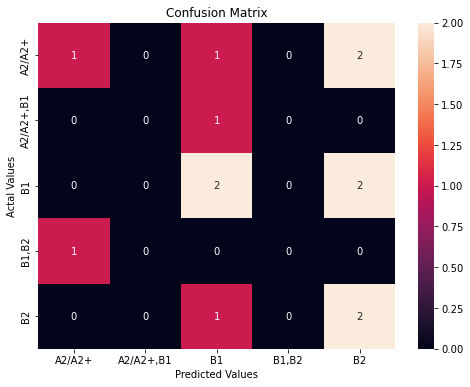


Accuracy score: 0.38



A2/A2+  A2/A2+,B1        B1  B1,B2        B2  weighted_avg
precision  0.500000        0.0  0.400000    0.0  0.333333      0.353846
recall     0.250000        0.0  0.500000    0.0  0.666667      0.384615
fscore     0.333333        0.0  0.444444    0.0  0.444444      0.341880
support    4.000000        1.0  4.000000    1.0  3.000000           NaN

In [126]:
svc_clf = SVC(**svc_best ,degree=3, random_state=12345)
eval_model(svc_clf, X_train_new, y_train, X_test_new, y_test)

### KNN evaluation

In [105]:
knn_clf = KNeighborsClassifier()
knn_params_grid = {
    'clf__n_neighbors': np.arange(1, 21),
    'clf__p': [1, 2],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__weights': ['uniform', 'distance']
}
knn_best = tune_hyper(knn_clf, knn_params_grid, X_train_new, y_train)

best weighted F1: 0.4195068027210884 with {'clf__algorithm': 'auto', 'clf__n_neighbors': 10, 'clf__p': 1, 'clf__weights': 'distance'} 


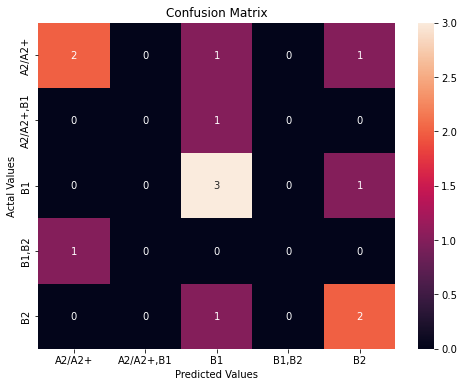

Accuracy score: 0.54


A2/A2+  A2/A2+,B1    B1  B1,B2        B2  weighted_avg
precision  0.666667        0.0  0.50    0.0  0.500000      0.474359
recall     0.500000        0.0  0.75    0.0  0.666667      0.538462
fscore     0.571429        0.0  0.60    0.0  0.571429      0.492308
support    4.000000        1.0  4.00    1.0  3.000000           NaN

In [124]:
knn_clf = KNeighborsClassifier(**knn_best)
eval_model(knn_clf, X_train_new, y_train, X_test_new, y_test)

### RFR evaluation 

In [119]:
rfr_clf = RandomForestClassifier()
rfr_params_grid = {
        "random_state": [12345],
        "n_estimators": [10, 100, 200, 500],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}
tune_hyper(rfr_clf, rfr_params_grid, X_train_new, y_train, standard=False)

best weighted F1: 0.42688350340136055 with {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 12345} 


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200,
 'random_state': 12345}

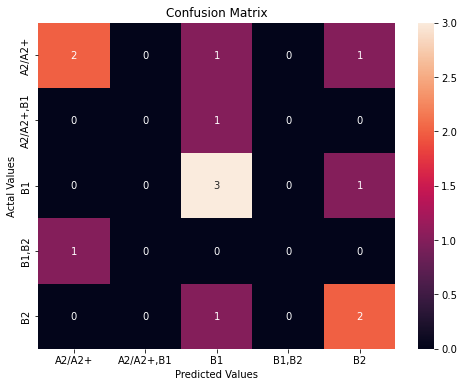

Accuracy score: 0.54


A2/A2+  A2/A2+,B1    B1  B1,B2        B2  weighted_avg
precision  0.666667        0.0  0.50    0.0  0.500000      0.474359
recall     0.500000        0.0  0.75    0.0  0.666667      0.538462
fscore     0.571429        0.0  0.60    0.0  0.571429      0.492308
support    4.000000        1.0  4.00    1.0  3.000000           NaN

In [123]:
rfr_clf = RandomForestClassifier(max_features='auto', min_samples_leaf=4, min_samples_split=2, n_estimators=200, random_state=12345)
eval_model(rfr_clf, X_train_new, y_train, X_test_new, y_test)

## Oridnal Regression

In [113]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_new)
X_test_std = scaler.transform(X_test_new)

mod_probit = OrderedModel(y_train, X_train_std, distr='probit')
res_probit = mod_probit.fit(method='bfgs', disp=False)
res_probit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  level   Log-Likelihood:                -59.047
Model:                   OrderedModel   AIC:                             196.1
Method:            Maximum Likelihood   BIC:                             285.4
Date:                Fri, 29 Jul 2022                                         
Time:                        14:24:26                                         
No. Observations:                  73                                         
Df Residuals:                      34                                         
Df Model:                          39                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
x1                  -4.4566      1.980     -2.251      0.024      -8.337      -0.576
x2                   0.6498      0.539      1.205      0.228      -0.407       1.707
x3                   4.0730      1.803      2.259      0.024       0.538       7.607
x4                   0.5044      1.040      0.485      0.628      -1.534       2.543
x5                  -1.7257      0.758     -2.278      0.023      -3.211      -0.241
x6                   0.8341      0.503      1.658      0.097      -0.152       1.820
x7                  -0.0227      0.871     -0.026      0.979      -1.731       1.685
x8                   0.4895      0.341      1.436      0.151      -0.179       1.158
x9                   1.5773      1.106      1.425      0.154      -0.591       3.746
x10                 -1.1327      0.663     -1.708      0.088      -2.432       0.167
x11                 -0.2056      0.354     -0.582      0.561      -0.898       0.487
x12                 -0.0741      1.257     -0.059      0.953      -2.538       2.390
x13                 -0.2864      0.795     -0.360      0.719      -1.845       1.272
x14                 -0.9263      0.591     -1.566      0.117      -2.085       0.233
x15                 -0.0761      1.178     -0.065      0.949      -2.384       2.232
x16                  1.9060      0.598      3.187      0.001       0.734       3.078
x17                  1.4269      0.397      3.598      0.000       0.650       2.204
x18                  2.5512      0.834      3.059      0.002       0.916       4.186
x19                  0.4153      0.777      0.535      0.593      -1.107       1.938
x20                 -0.2403      0.622     -0.386      0.699      -1.460       0.979
x21                  8.7552      9.940      0.881      0.378     -10.728      28.238
x22                  0.9560      1.806      0.529      0.597      -2.585       4.497
x23                  1.5971      0.880      1.815      0.070      -0.128       3.322
x24                 -0.3622      0.894     -0.405      0.685      -2.114       1.390
x25                 -3.2238      1.384     -2.329      0.020      -5.936      -0.511
x26                -10.5873     10.605     -0.998      0.318     -31.372      10.197
x27                  2.6472      1.878      1.410      0.159      -1.033       6.328
x28                  1.0480      0.569      1.842      0.065      -0.067       2.163
x29                  1.3284      0.770      1.724      0.085      -0.181       2.838
x30                 -1.0771      0.697     -1.546      0.122      -2.442       0.288
x31                  3.6436      4.658      0.782      0.434      -5.485      12.772
x32                 -0.6734      0.542     -1.242      0.214      -1.736       0.390
x33                 -1.9469      1.240     -1.570      0.116      -4.377       0.483
x34                 -0.0381      1.129     -0.034      0.973      -2.251       2.175
x35              

In [128]:
predicted = res_probit.model.predict(res_probit.params, exog=X_test_std)
pred_choice = predicted.argmax(1)
np.asarray(y_test.values.codes)
or_score = accuracy_score(np.asarray(y_test.values.codes), pred_choice)

In [129]:
print(f'accuracy score {or_score:.2f}')

accuracy score 0.54


## Summary  
- we cleaned and parsed subtitles from 86 movies into numerical features 
- from the Movie df analysis we have two observations
  - features do not correlate clearly with the target 
  - the distribution of each features is very wide, even for movies with same label
- several classifiers were experimented via hyperparameters tuning and cross validation
- Feature importance tests allow us to select features
- We developed several ml solutions to predicit the difficulty level
    - KNN and RFR models score the highest accuracy of 0.54 with a weighted F1 score of 0.5
- results not ideal due to 
    - highly imballanced data
    - the features do not provide enough infos, as the correlation with labels is weak
    - not enough samples for a 5 class classification
  
## Outlook
- try to get more data (86 labeled samples are too less)
- use neural network 
- use semi supervised machine learning

In [130]:
!jupyter nbconvert --to html --no-input 100_films.ipynb

[NbConvertApp] Converting notebook 100_films.ipynb to html
[NbConvertApp] Writing 4891592 bytes to 100_films.html
